<a href="https://colab.research.google.com/github/GavraMG/StructFlow-Colab/blob/main/StructFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧬 StructFlow Colab Guide   

This notebook walks you through generating CellPACK recipes from sequence and simulation data, predicting structures with AlphaFold, and preparing JSON files for 3D modeling.

---

## ✅ Step 1: Input Protein Sequences  

Mount your **Google Drive** and load a CSV file with protein sequences.  

📁 **Location:** `/MyDrive/CellPACK/Protein_Sequences_Template.csv`  

Each row must contain:
- `id`: unique identifier  
- `sequence`: protein sequence (AAs)

This cell will:
- Mount Google Drive
- Load your sequence CSV
- Prepare job folders for each protein
- Save working copy into Colab

---

## 🔬 Step 1.1: Run AlphaFold Prediction (ColabFold)

Run **AlphaFold2** predictions for all sequences using ColabFold.  

You can customize:
- `template_mode`: `"none"`, `"pdb100"`, or `"custom"`
- `num_relax`: `0`, `1`, or `5` relaxation steps

The model:
- Automatically detects if the sequence is a complex
- Saves predicted `.pdb` files to `/content/proteins`

---

## 📦 Step 2: Connect Input Files for Recipe Generation  

Copy required metadata and simulation files for your specific cell model.

📁 **Expected Google Drive Folder:** `/MyDrive/CellPACK/CellPACK_Input_Files/`

Required files include:
- `protein_data.json`
- `genes_data.json`
- `simulation-1.h5`
- `getSeriesData_monomers1.json`
- `getSeriesData_complexes1.json`
- `WholeCellData.xlsx`
- `ingredient_function.csv`
- `method_selection.csv`
- `compartment_updated.json`
- `updated_function_dictionary.json`
- `all_dict.json`

These will be copied to: `/content/input_files/`

---

## 🧱 Step 2.1: Connect CellPACK Data Assets  

This step pulls data assets used during 3D model construction.  

📁 **Drive Source Folder:** `/MyDrive/CellPACK/CellPACK_Data/`

Copied folders:
- ✅ `lattices/` — required for LatticeNucleoid modeling  
- 🎨 `palettes/` — optional visualization files  
- 💾 `proteins/` — your predicted AlphaFold models (auto-copied)

Output directory: `/content/cellPACK_Data`

---

## 🧪 Step 2.2: Generate CSV Recipes (Auto / Curated)  

Choose how you'd like to generate your recipe files:

```python
recipe_mode = "both"  # Options: "curated", "auto", "both"

# 🔧 Definitions:

"curated" – Generates a recipe using manually curated homology models and experimentally validated PDB structures.

"auto" – Includes only proteins with existing solved homologs, without applying any homology modeling.

"both" – Produces both the curated and automated recipe variants for side-by-side use or comparison.

---

## 🌟 Step 2.3: Customize Frame Numbers (Copy Number Control)

Frame numbers determine which snapshot of the `.h5` simulation is used to calculate molecular copy numbers. This step is essential for producing realistic densities in the final 3D cell model.

In the builder script (`WC-MG-CellPACK-RecipeBuilder-short.py`), locate the following lines:

- `frame_mono = 149`
- `frame_complex = 150`

You can modify these values to target different timepoints in the simulation.

### 🔢 Example Frame Options:
- `frames_m = [150, 1185, 6974]`  ← for monomers
- `frames_c = [146, 1190, 6961]`  ← for complexes

🔀 Change these values to explore how molecular counts vary across different simulation snapshots.

---

## 📄 Step 3: Convert CSV to JSON for CellPACK-GPU

Once you have generated `auto_root.csv` or `curated_root.csv`, the next step is to convert it into a CellPACK-compatible JSON recipe.

📁 These files are saved automatically in your Colab workspace inside the folder:  
`scripts_output/`

🔗 Open the Mesoscope Web Interface:  
👉 https://mesoscope.scripps.edu/beta/#

### 📥 To convert your CSV:

1. Click **"Load"** (top left) and upload your `auto_root.csv` or `curated_root.csv` from the `scripts_output` folder.  
2. Your ingredients will appear in the **Recipe Table** (bottom panel).  
3. Click **"Save"** → **cellPACK-gpu recipe** to export the `.json` file.

💡 This JSON file can now be used with **CellPACK-GPU** or **Simularium** to assemble and visualize your 3D whole-cell model.

---

## 🚫 Step 4: Run CellPACK-GPU Locally (Manual Setup Required)

Due to limited access to internal automation scripts, **this step can no longer be executed directly via the Colab pipeline**.

Instead, users can manually download and run **CellPACK-GPU** using the official release.

---

### 📦 Download CellPACK-GPU

🔗 Download it from the official GitHub release page:  
👉 [MycoplasmaGenitalium v1.0 – CellPACK-GPU](https://github.com/ccsb-scripps/MycoplasmaGenitalium/releases/tag/v1.0)

1. Scroll down to the **Assets** section.
2. Download the `cellPACKGPU.zip` file for your operating system.

---

### 🧰 How to Use It

1. **Extract** the ZIP file to a known location on your computer (e.g., Desktop or Documents).
2. Inside the extracted folder, locate the file named:
   - `cellPACKgpu.exe` (on Windows)
3. **Double-click** to launch the application.

You’ll see the CellPACK-GPU interface, similar to a Unity-based simulation window. This tool allows you to load your `.json` recipe (from Mesoscope) and simulate spatial packing.

---

## 👥 Contributors

**Markus Gavra** and **Evan Bucholski**  
Second-year Software Engineering students at the University of Guelph, with a focus on applying computational tools to real-world scientific challenges.


### Pushing the boundaries of what's possible—one cell at a time.


## Step 1: Predicting Protein Structures with AlphaFold

In [ ]:
#@title Input protein sequences from Drive, then hit `Runtime` → `Run all`

from google.colab import drive
import pandas as pd
import os
import re
import hashlib
from sys import version_info

python_version = f"{version_info.major}.{version_info.minor}"

# Mount Google Drive
drive.mount('/content/drive')

# Mount Drive
drive.mount('/content/drive')

# ==== USER INPUT: File inside MyDrive/CellPACK ====
csv_filename_input = "protein_sequences.csv"  #@param {type:"string"}
full_csv_path = f"/content/drive/MyDrive/CellPACK/{csv_filename_input}"

# Check and read file
if not os.path.exists(full_csv_path):
    raise FileNotFoundError(f"❌ File not found at: {full_csv_path}")

sequences_df = pd.read_csv(full_csv_path)
sequences_df = sequences_df.dropna(subset=["id", "sequence"]).reset_index(drop=True)

print(f"✅ Loaded {len(sequences_df)} protein sequences from: {csv_filename_input}")

# Parameters
jobname = 'proteins'
num_relax = 0  #@param [0, 1, 5] {type:"raw"}
template_mode = "none"  #@param ["none", "pdb100", "custom"]
use_amber = num_relax > 0

# Handle templates
from google.colab import files
if template_mode == "pdb100":
    use_templates = True
    custom_template_path = None
elif template_mode == "custom":
    custom_template_path = os.path.join(jobname, "template")
    os.makedirs(custom_template_path, exist_ok=True)
    uploaded_templates = files.upload()
    for fn in uploaded_templates.keys():
        os.rename(fn, os.path.join(custom_template_path, fn))
    use_templates = True
else:
    custom_template_path = None
    use_templates = False

# Hash function
def add_hash(x, y):
    return x + "_" + hashlib.sha1(y.encode()).hexdigest()[:5]

# Save working copy into content
output_folder = "/content"
os.makedirs(output_folder, exist_ok=True)

working_copy_path = os.path.join(output_folder, "protein_sequences.csv")
sequences_df.to_csv(working_copy_path, index=False)

print(f"📄 Saved working copy to: {working_copy_path}")




Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Loaded 3 protein sequences from: protein_sequences.csv
📄 Saved working copy to: /content/protein_sequences.csv


In [ ]:
#@title Install dependencies
%%time
import os
USE_AMBER = use_amber
USE_TEMPLATES = use_templates
PYTHON_VERSION = python_version

if not os.path.isfile("COLABFOLD_READY"):
  print("installing colabfold...")
  os.system("pip install -q --no-warn-conflicts 'colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold'")
  if os.environ.get('TPU_NAME', False) != False:
    os.system("pip uninstall -y jax jaxlib")
    os.system("pip install --no-warn-conflicts --upgrade dm-haiku==0.0.10 'jax[cuda12_pip]'==0.3.25 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabfold colabfold")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/alphafold alphafold")
  os.system("touch COLABFOLD_READY")

if USE_AMBER or USE_TEMPLATES:
  if not os.path.isfile("CONDA_READY"):
    print("installing conda...")
    os.system("wget -qnc https://github.com/conda-forge/miniforge/releases/latest/download/Miniforge3-Linux-x86_64.sh")
    os.system("bash Miniforge3-Linux-x86_64.sh -bfp /usr/local")
    os.system("mamba config --set auto_update_conda false")
    os.system("touch CONDA_READY")

if USE_TEMPLATES and not os.path.isfile("HH_READY") and USE_AMBER and not os.path.isfile("AMBER_READY"):
  print("installing hhsuite and amber...")
  os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 openmm=8.2.0 python='{PYTHON_VERSION}' pdbfixer")
  os.system("touch HH_READY")
  os.system("touch AMBER_READY")
else:
  if USE_TEMPLATES and not os.path.isfile("HH_READY"):
    print("installing hhsuite...")
    os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 python='{PYTHON_VERSION}'")
    os.system("touch HH_READY")
  if USE_AMBER and not os.path.isfile("AMBER_READY"):
    print("installing amber...")
    os.system(f"mamba install -y -c conda-forge openmm=8.2.0 python='{PYTHON_VERSION}' pdbfixer")
    os.system("touch AMBER_READY")

installing colabfold...
CPU times: user 103 ms, sys: 13.8 ms, total: 117 ms
Wall time: 35.1 s


In [ ]:
#@markdown ### MSA options (custom MSA upload, single sequence, pairing mode)
msa_mode = "mmseqs2_uniref_env" #@param ["mmseqs2_uniref_env", "mmseqs2_uniref","single_sequence","custom"]
pair_mode = "unpaired_paired" #@param ["unpaired_paired","paired","unpaired"] {type:"string"}
#@markdown - "unpaired_paired" = pair sequences from same species + unpaired MSA, "unpaired" = seperate MSA for each chain, "paired" - only use paired sequences.

# decide which a3m to use
if "mmseqs2" in msa_mode:
  a3m_file = os.path.join(jobname,f"{jobname}.a3m")

elif msa_mode == "custom":
  a3m_file = os.path.join(jobname,f"{jobname}.custom.a3m")
  if not os.path.isfile(a3m_file):
    custom_msa_dict = files.upload()
    custom_msa = list(custom_msa_dict.keys())[0]
    header = 0
    import fileinput
    for line in fileinput.FileInput(custom_msa,inplace=1):
      if line.startswith(">"):
         header = header + 1
      if not line.rstrip():
        continue
      if line.startswith(">") == False and header == 1:
         query_sequence = line.rstrip()
      print(line, end='')

    os.rename(custom_msa, a3m_file)
    queries_path=a3m_file
    print(f"moving {custom_msa} to {a3m_file}")

else:
  a3m_file = os.path.join(jobname,f"{jobname}.single_sequence.a3m")
  with open(a3m_file, "w") as text_file:
    text_file.write(">1\n%s" % query_sequence)

In [ ]:
#@markdown ### Advanced settings
model_type = "auto" #@param ["auto", "alphafold2_ptm", "alphafold2_multimer_v1", "alphafold2_multimer_v2", "alphafold2_multimer_v3", "deepfold_v1", "alphafold2"]
#@markdown - if `auto` selected, will use `alphafold2_ptm` for monomer prediction and `alphafold2_multimer_v3` for complex prediction.
#@markdown Any of the mode_types can be used (regardless if input is monomer or complex).
num_recycles = "3" #@param ["auto", "0", "1", "3", "6", "12", "24", "48"]
#@markdown - if `auto` selected, will use `num_recycles=20` if `model_type=alphafold2_multimer_v3`, else `num_recycles=3` .
recycle_early_stop_tolerance = "auto" #@param ["auto", "0.0", "0.5", "1.0"]
#@markdown - if `auto` selected, will use `tol=0.5` if `model_type=alphafold2_multimer_v3` else `tol=0.0`.
relax_max_iterations = 200 #@param [0, 200, 2000] {type:"raw"}
#@markdown - max amber relax iterations, `0` = unlimited (AlphaFold2 default, can take very long)
pairing_strategy = "greedy" #@param ["greedy", "complete"] {type:"string"}
#@markdown - `greedy` = pair any taxonomically matching subsets, `complete` = all sequences have to match in one line.
calc_extra_ptm = False #@param {type:"boolean"}
#@markdown - return pairwise chain iptm/actifptm

#@markdown #### Sample settings
#@markdown -  enable dropouts and increase number of seeds to sample predictions from uncertainty of the model.
#@markdown -  decrease `max_msa` to increase uncertainity
max_msa = "auto" #@param ["auto", "512:1024", "256:512", "64:128", "32:64", "16:32"]
num_seeds = 1 #@param [1,2,4,8,16] {type:"raw"}
use_dropout = False #@param {type:"boolean"}

num_recycles = None if num_recycles == "auto" else int(num_recycles)
recycle_early_stop_tolerance = None if recycle_early_stop_tolerance == "auto" else float(recycle_early_stop_tolerance)
if max_msa == "auto": max_msa = None

#@markdown #### Save settings
save_all = False #@param {type:"boolean"}
save_recycles = False #@param {type:"boolean"}
save_to_google_drive = False #@param {type:"boolean"}
#@markdown -  if the save_to_google_drive option was selected, the result zip will be uploaded to your Google Drive
dpi = 200 #@param {type:"integer"}
#@markdown - set dpi for image resolution

if save_to_google_drive:
  from pydrive2.drive import GoogleDrive
  from pydrive2.auth import GoogleAuth
  from google.colab import auth
  from oauth2client.client import GoogleCredentials
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  print("You are logged into Google Drive and are good to go!")

#@markdown Don't forget to hit `Runtime` -> `Run all` after updating the form.

📄 Loading queries from: /content/protein_sequences.csv
🚀 Running AlphaFold prediction for: PREDICATING_PROTEINS
2025-05-30 02:53:15,486 Running on GPU
2025-05-30 02:53:15,491 Found 5 citations for tools or databases
2025-05-30 02:53:15,491 Query 1/3: P001 (length 59)


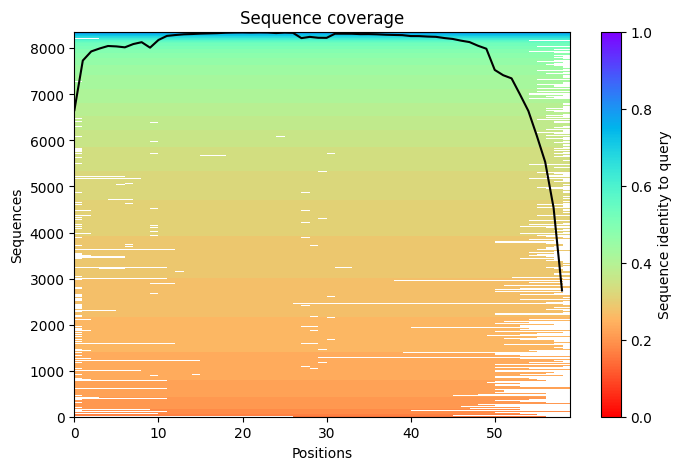

2025-05-30 02:53:53,650 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=96.6 pTM=0.755
2025-05-30 02:53:58,709 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=96.5 pTM=0.759 tol=0.285
2025-05-30 02:53:58,710 alphafold2_ptm_model_1_seed_000 took 31.3s (1 recycles)


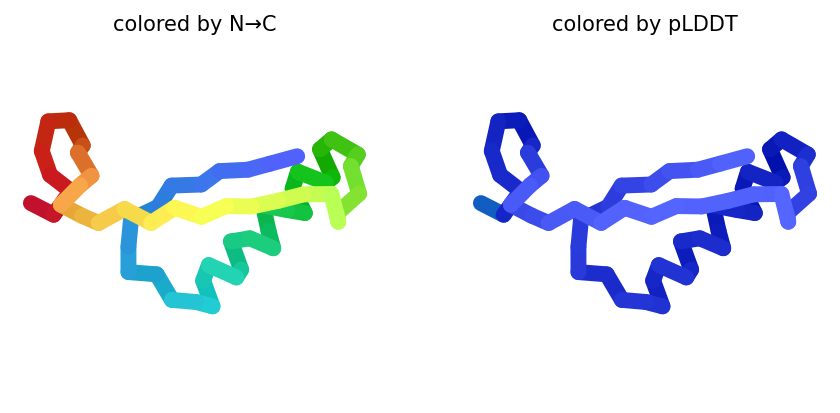

2025-05-30 02:54:03,947 alphafold2_ptm_model_2_seed_000 recycle=0 pLDDT=97 pTM=0.761
2025-05-30 02:54:09,078 alphafold2_ptm_model_2_seed_000 recycle=1 pLDDT=97 pTM=0.766 tol=0.367
2025-05-30 02:54:09,079 alphafold2_ptm_model_2_seed_000 took 10.2s (1 recycles)


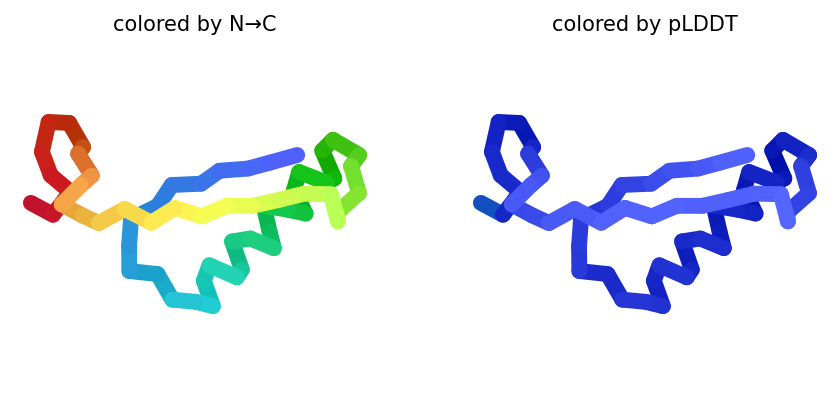

2025-05-30 02:54:14,288 alphafold2_ptm_model_3_seed_000 recycle=0 pLDDT=97.2 pTM=0.775
2025-05-30 02:54:19,379 alphafold2_ptm_model_3_seed_000 recycle=1 pLDDT=97.4 pTM=0.782 tol=0.298
2025-05-30 02:54:19,380 alphafold2_ptm_model_3_seed_000 took 10.2s (1 recycles)


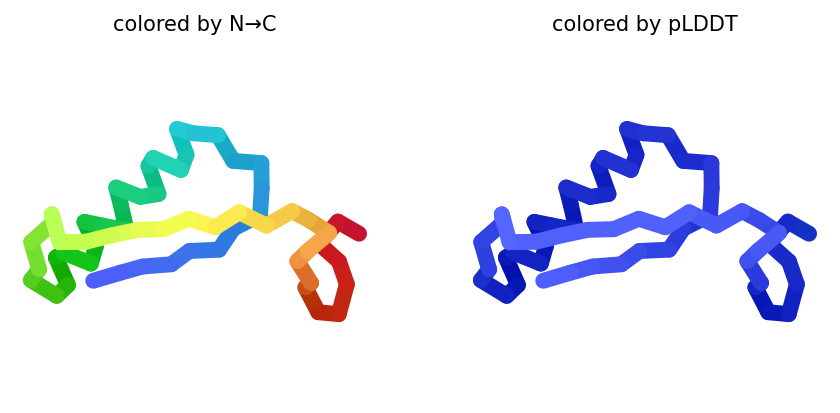

2025-05-30 02:54:24,534 alphafold2_ptm_model_4_seed_000 recycle=0 pLDDT=97.4 pTM=0.774
2025-05-30 02:54:29,571 alphafold2_ptm_model_4_seed_000 recycle=1 pLDDT=97.4 pTM=0.781 tol=0.315
2025-05-30 02:54:29,572 alphafold2_ptm_model_4_seed_000 took 10.1s (1 recycles)


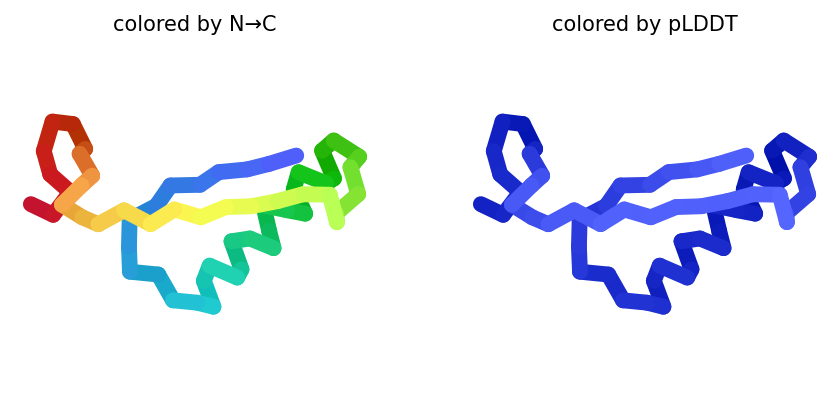

2025-05-30 02:54:34,650 alphafold2_ptm_model_5_seed_000 recycle=0 pLDDT=97.4 pTM=0.784
2025-05-30 02:54:39,659 alphafold2_ptm_model_5_seed_000 recycle=1 pLDDT=96.9 pTM=0.783 tol=0.27
2025-05-30 02:54:39,660 alphafold2_ptm_model_5_seed_000 took 10.0s (1 recycles)


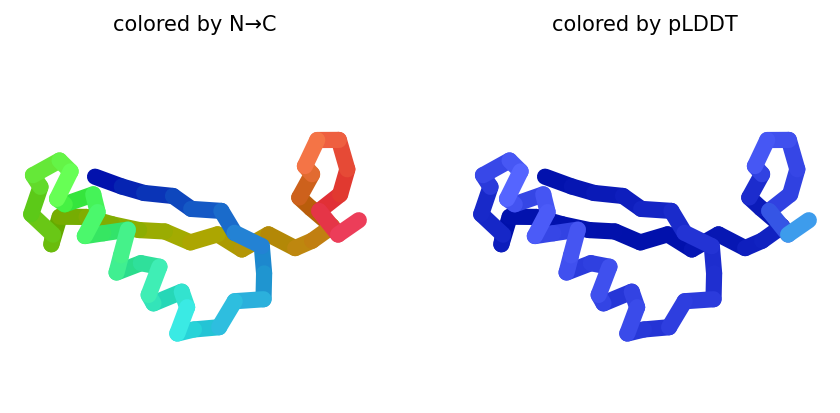

2025-05-30 02:54:39,794 reranking models by 'plddt' metric
2025-05-30 02:54:39,794 rank_001_alphafold2_ptm_model_4_seed_000 pLDDT=97.4 pTM=0.781
2025-05-30 02:54:39,795 rank_002_alphafold2_ptm_model_3_seed_000 pLDDT=97.4 pTM=0.782
2025-05-30 02:54:39,795 rank_003_alphafold2_ptm_model_2_seed_000 pLDDT=97 pTM=0.766
2025-05-30 02:54:39,795 rank_004_alphafold2_ptm_model_5_seed_000 pLDDT=96.9 pTM=0.783
2025-05-30 02:54:39,796 rank_005_alphafold2_ptm_model_1_seed_000 pLDDT=96.5 pTM=0.759
2025-05-30 02:54:40,835 Query 2/3: P002 (length 59)


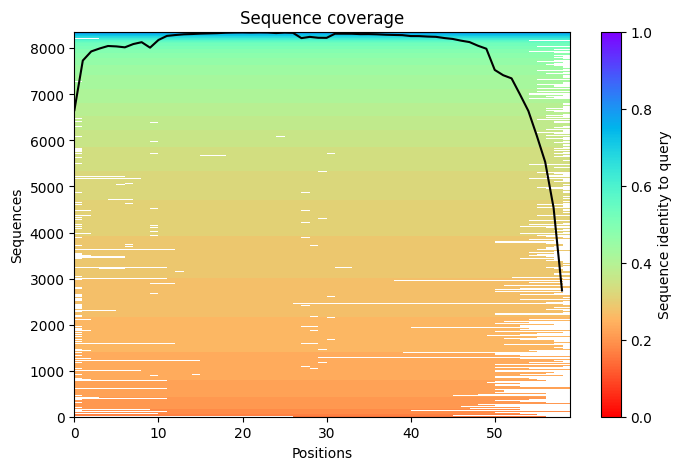

KeyboardInterrupt: 

In [ ]:
#@title 🚀 Run Prediction
display_images = True  #@param {type:"boolean"}

import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from Bio import BiopythonDeprecationWarning
warnings.simplefilter(action='ignore', category=BiopythonDeprecationWarning)

from colabfold.download import download_alphafold_params, default_data_dir
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type
from colabfold.colabfold import plot_protein
from colabfold.plot import plot_msa_v2

from pathlib import Path
import matplotlib.pyplot as plt
import os
import numpy as np

python_version = f"{sys.version_info.major}.{sys.version_info.minor}"

# GPU check
try:
    K80_chk = os.popen('nvidia-smi | grep "Tesla K80" | wc -l').read()
    if "1" in K80_chk:
        print("⚠️ WARNING: Found GPU Tesla K80. Limited to sequences < 1000 residues.")
        os.environ.pop("TF_FORCE_UNIFIED_MEMORY", None)
        os.environ.pop("XLA_PYTHON_CLIENT_MEM_FRACTION", None)
except:
    pass

# === Parameters ===
jobname = "PREDICATING_PROTEINS"
queries_path = "/content/protein_sequences.csv"
result_dir = jobname
os.makedirs(result_dir, exist_ok=True)

# === Plot Callbacks ===
def input_features_callback(input_features):
    if display_images:
        plot_msa_v2(input_features)
        plt.show()
        plt.close()

def prediction_callback(protein_obj, length, prediction_result, input_features, mode):
    model_name, relaxed = mode
    if not relaxed and display_images:
        fig = plot_protein(protein_obj, Ls=length, dpi=150)
        plt.show()
        plt.close()

# === Setup Logging and Download Parameters ===
log_filename = os.path.join(result_dir, "log.txt")
setup_logging(Path(log_filename))

print(f"📄 Loading queries from: {queries_path}")
queries, is_complex = get_queries(queries_path)
model_type_final = set_model_type(is_complex, "auto")

download_alphafold_params(model_type_final, Path("."))

# === Run Prediction ===
print(f"🚀 Running AlphaFold prediction for: {jobname}")
results = run(
    queries=queries,
    result_dir=result_dir,
    use_templates=use_templates,
    custom_template_path=custom_template_path,
    num_relax=num_relax,
    msa_mode="mmseqs2_uniref_env",  # or your preferred mode
    model_type=model_type_final,
    num_models=5,
    num_recycles=3,
    relax_max_iterations=0,
    recycle_early_stop_tolerance=0.5,
    num_seeds=1,
    use_dropout=False,
    model_order=[1, 2, 3, 4, 5],
    is_complex=is_complex,
    data_dir=Path("."),
    keep_existing_results=False,
    rank_by="auto",
    pair_mode="unpaired+paired",
    pairing_strategy="greedy",
    stop_at_score=float(100),
    prediction_callback=prediction_callback,
    dpi=150,
    zip_results=False,
    save_all=False,
    max_msa=None,
    use_cluster_profile=False,
    input_features_callback=input_features_callback,
    save_recycles=False,
    user_agent="colabfold/google-colab-main",
    calc_extra_ptm=False,
)

# === Organize Top-Ranked PDB Output Only ===
proteins_dir = "proteins"
os.makedirs(proteins_dir, exist_ok=True)

seen_prefixes = set()

for file in sorted(os.listdir(result_dir)):
    if not file.endswith(".pdb"):
        continue
    if "_rank_001_" not in file:
        continue  # skip lower-ranked predictions

    # Extract the base protein ID (e.g., "P001")
    base_id = file.split("_")[0]
    if base_id in seen_prefixes:
        continue  # already saved top model for this protein

    seen_prefixes.add(base_id)
    src = os.path.join(result_dir, file)
    dst = os.path.join(proteins_dir, f"{base_id}.pdb")  # clean name
    os.rename(src, dst)

print(f"📁 Top-ranked PDB files moved to: {proteins_dir}")
print("✅ Only rank_001 structures saved.")



## Step 2: Building the Cell Recipe with CellPACK


In [ ]:
#@title Connecting and Import CellPACK Input_Files from Google Drive (Press `Runtime` → `Run all`)

from google.colab import drive
import os, shutil

# Mount Google Drive
drive.mount('/content/drive')

# Define paths
drive_base = "/content/drive/MyDrive/CellPACK/CellPACK_Input_Files"
local_base = "/content/input_files"
os.makedirs(local_base, exist_ok=True)

# Required and optional files
required_files = [
    "protein_data.json",
    "genes_data.json",
    "simulation-1.h5",
    "getSeriesData_monomers1.json",
    "getSeriesData_complexes1.json",
    "WholeCellData.xlsx",
    "ingredient_function.csv",
    "method_selection.csv",
    "compartment_updated.json",
    "updated_function_dictionary.json",
    "all_dict.json"
]

optional_files = [
    "HHpred_scores.csv",
    "S3K-Transcription units.csv",
    "uniprot.csv"
]

missing_required_files = []

print("📁 Copying required files from Google Drive...")
for fname in required_files + optional_files:
    src = os.path.join(drive_base, fname)
    dst = os.path.join(local_base, fname)

    if os.path.exists(src):
        shutil.copy(src, dst)
        print(f"✅ Copied: {fname}")
    elif fname in required_files:
        missing_required_files.append(fname)
        print(f"❌ Missing: {fname}")

# Final message
if missing_required_files:
    print("\n⚠️ The following required files were NOT found in your Google Drive folder:")
    for f in missing_required_files:
        print(f" - {f}")
else:
    print("\n🎉 All required files successfully copied to /content/input_files")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📁 Copying required files from Google Drive...
✅ Copied: protein_data.json
✅ Copied: genes_data.json
✅ Copied: simulation-1.h5
✅ Copied: getSeriesData_monomers1.json
✅ Copied: getSeriesData_complexes1.json
✅ Copied: WholeCellData.xlsx
✅ Copied: ingredient_function.csv
✅ Copied: method_selection.csv
✅ Copied: compartment_updated.json
✅ Copied: updated_function_dictionary.json
✅ Copied: all_dict.json
✅ Copied: HHpred_scores.csv
✅ Copied: S3K-Transcription units.csv
✅ Copied: uniprot.csv

🎉 All required files successfully copied to /content/input_files


In [ ]:
#@title Connecting and Import CellPACK DATA from Google Drive (Press `Runtime` → `Run all`)

from google.colab import drive
import os
import shutil

# Mount Google Drive
drive.mount('/content/drive')

# Source: where your folders are in Drive
drive_base = "/content/drive/MyDrive/CellPACK/CellPACK_Data"

# Target: destination in Colab
colab_target = "/content/cellPACK_Data"
os.makedirs(colab_target, exist_ok=True)

# Define which folders to copy
required_folders = ["lattices"]
optional_folders = ["palettes"]
missing = []

# Copy folders from Google Drive
for folder in required_folders + optional_folders:
    src = os.path.join(drive_base, folder)
    dst = os.path.join(colab_target, folder)

    if os.path.isdir(src):
        if os.path.exists(dst):
            shutil.rmtree(dst)
        shutil.copytree(src, dst)
        print(f"✅ Copied '{folder}' from Google Drive to /content/cellPACK_Data")
    elif folder in required_folders:
        missing.append(folder)
        print(f"❌ MISSING in Drive: '{folder}'")

# Add Proteins folder from local Colab
local_protein_folder = "/content/proteins"
target_protein_folder = os.path.join(colab_target, "proteins")

if os.path.isdir(local_protein_folder):
    if os.path.exists(target_protein_folder):
        shutil.rmtree(target_protein_folder)
    shutil.copytree(local_protein_folder, target_protein_folder)
    print("✅ Added local 'proteins' folder to /content/cellPACK_Data")
else:
    print("❌ 'proteins' folder not found in /content")

# Final report
if missing:
    print("\n⚠️ Missing required folder(s):", ", ".join(missing))
else:
    print("\n🎉 All required folders copied successfully to /content/cellPACK_Data")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Copied 'lattices' from Google Drive to /content/cellPACK_Data
✅ Copied 'palettes' from Google Drive to /content/cellPACK_Data
✅ Added local 'proteins' folder to /content/cellPACK_Data

🎉 All required folders copied successfully to /content/cellPACK_Data


In [ ]:
#@title Import CellPACK Functions script for use


%%writefile WC-MG-CellPACK-functions.py
# -*- coding: utf-8 -*-
"""
Created on Thu Jul  8 13:14:28 2021

@author: MM
"""

import re
import os
import json
import h5py
import numpy as np
import csv
import shutil
from openpyxl import load_workbook

# -*- coding: utf-8 -*-
"""
Created on Thu Jul  8 13:14:28 2021

@author: MM
"""
import re
import os
import json
import h5py
import numpy as np
import csv
import shutil
import h5py
from openpyxl import load_workbook

#----------------------------------------------------------------------------
# FUNCTIONS TO GET DATA FROM WC-SIMULATIONS and ASSEMBLE A DRAFT RECIPE REDABLE ON MESOSCOPE
#----------------------------------------------------------------------------
#INPUT FILES INFO
    #to run all the following code you need:
    # 1) protein database and gene database from cover wholecellkb: 'protein_data.json' | 'genes_data.json'
    # 2) simulation file .h5 format: simulation-1.h5 (downloaded from http://www.wholecellsimdb.org/simulation_batch/1))
    # 3) json file with positions of DNA binding monomers/complexes: getSeriesData_monomers1.json | getSeriesData_complex1.json
    # downloaded from: http://www.wholecellviz.org/getSeriesData.php?sim_id=2011_10_19_02_53_45_1&class_name=Chromosome&attr_name=monomerBoundSites
    # and http://www.wholecellviz.org/getSeriesData.php?sim_id=2011_10_19_02_53_45_1&class_name=Chromosome&attr_name=complexBoundSites
    # 4) frame number (note that when extracting data from getSeriesData_monomers1.json | getSeriesData_complex1.json or sim
    #the frame number is different due to the file type but they refer to the same frame in the simulation.
    #Complexes and monomers do not have the same time stamps because

#frames json: 150(mono)/146(complex); 1185(mono)/1190 (complex); 6974 (mono)/6961(complex)
#frames when working with the hdf5 files is: (frame json) -1
#frames sim: 149(mono)/145(complex); 1184(mono)/1189(complex); 6973(mono)/6960(complex)

#input files:
input_dir ='input_files'+os.sep

#outfput folder:
output_dir = output_folder = 'scripts_output'+os.sep

#holds DNA binding prot positions for monomers
fname_m = input_dir+'getSeriesData_monomers1.json'
#holds DNA binding prot positions for complexes
fname_c = input_dir+'getSeriesData_complexes1.json'
#simulation #1-1
sim = input_dir+'simulation-1.h5'

#TRANSCRIPTION UNIT
    #creates a dictionary where every monomer is associated with its transcription unit, gene length, coords, etc
    #attention: the function uses some actual file and refers to actual file locations (ie csvf, input_dir, 'genes_data.json')

    #you need:
    #       hdf5 file
    #       beware of 'S3K-Transcription units.csv'
    #       'protein_data.json' downloaded from http://www.wholecellkb.org/
    #       'genes_data.json' downloaded from http://www.wholecellkb.org/

def prepare_dictionary_index(sim):
    x = h5py.File(sim)
    #create the variable for the labels
    labels_mono= x.get("states/ProteinMonomer/counts/labels/0")
    #make a numpy array with the monomer labels
    array_mono = np.array(labels_mono)
    #make initial dictionary index to protein dictionary and to gene ie 482: {'protID': 'MG_470_MONOMER'}
    index_dict = {}
    for i in array_mono:
        if '-nascent'.encode() in i:
            index = np.where(array_mono == i)[0][0]+1
            #nb. i use decode because of p3 issues with ascii
            index_dict[index]={'protID':i.decode().split('-')[0]}
    #make a ditionary for trancription units ie. 'TU_335': {'type': 'polycistronic', 'length_TU': 2766, 'start_tu': 577268}
    tu = {}
    #input is a csv file
    csvf = input_dir+'S3K-Transcription units.csv'
    with open(csvf) as csvfile:
        csvreader = csv.reader(csvfile)
        header = next(csvreader)
        header = next(csvreader)
        header = next(csvreader)
        for row in csvreader:
            TU = row[0] #TU column
            gen = row[3] #genes column
            leng = row[5] #length genes column
            start_coord = row[4] #start coordinate column
            product = row[2]
            if 'mRNA' in row[2]:
                if ',' in gen: #',' means there are multiple genes in the same TU -> polycistronic
                    tu[TU]={'type':'polycistronic', 'length_TU':int(leng)+1, 'start_tu':int(start_coord), 'product':product}
                else: #no ',' means a single gene in the TU -> monocistronic
                    tu[TU]={'type':'monocistronic', 'length_TU':int(leng)+1, 'start_tu':int(start_coord), 'product':product}
            else:
                if ',' in gen:
                    tu[TU]={'type':'polycistronic', 'length_TU':int(leng)+1, 'start_tu':int(start_coord), 'product':product}
                else:
                    tu[TU]={'type':'monocistronic', 'length_TU':int(leng)+1, 'start_tu':int(start_coord), 'product':product}
    genes = json.load(open(input_dir+'genes_data.json', 'r'))
    #make initial dictionary index for genes
    gene_dic={}
    for agene in genes['data']:
        gene_dic[agene['wid']]={'TU':agene['transcription_units'][0], 'gene_length':agene['length'], 'type':agene['type'][0], 'length_TU':''}
    for i in gene_dic:
        if gene_dic[i]['TU'] in tu:
            gene_dic[i].update({'length_TU':tu[gene_dic[i]['TU']]['length_TU']})
    #update the index_dict to include tu, gene len, coord, direction, type etc
    #ie. 482: {'protID': 'MG_470_MONOMER', 'gene': 'MG_470', 'gene_length': 810, 'TU': 'TU_335',  'coord_gene': 579224,
    #          'direction': 'Reverse', 'type': 'polycistronic', 'length_TU': 2766, 'coord_tu': 577268}
    covert = json.load(open(input_dir+'protein_data.json', 'r'))
    for i in index_dict:
        name = index_dict[i]['protID']
        for aname in covert['data']:
            if name == aname['wid']:
                index_dict[i].update({'gene':aname['gene']})
                break
        gene = index_dict[i]['gene']
        for agene in genes['data']:
            if gene == agene['wid']:
                index_dict[i].update({'gene_length':int(agene['length']), 'TU':agene['transcription_units'][0], 'coord_gene':int(agene['coordinate']), 'direction':agene['direction']})
        unit = index_dict[i]['TU']
        for u in tu:
            if unit == u:
                index_dict[i].update({'type':tu[u]['type'],'length_TU':tu[u]['length_TU'], 'coord_tu':tu[u]['start_tu']})
    return index_dict, gene_dic

#usage
index_dict, genes_dict =prepare_dictionary_index(sim)


def dna_binding_list(json_data):
    covert = json.load(open(input_dir+json_data, 'r'))
    l =[]
    d={}
    for i in covert['data']:
        if i['model']=='ProteinMonomer':
            if i['dna_footprint']!= None :
            #print i['dna_footprint']
                l.append(i['wid'])
                d[i['wid']]={'dna_footprint':i['dna_footprint']['length']}
        if i['model']=='ProteinComplex':
            if i['dna_footprint']!= None :
           #print i['dna_footprint']
               l.append(i['wid'])
               d[i['wid']]={'dna_footprint':i['dna_footprint']['length']}
    return l, d
##usage
##this is a list of all DNA binding proteins in the simulation
dna_bp_list, dna_bp_dictionary = dna_binding_list('protein_data.json')

#PROTEIN COORD CHROMOSOME
    #makes a csv file with the proteinid+position+strand from json file
    #NB if you want this to work, write the PRECISE frame number found in the json file
    #this is based on json so the frame you use here corresponds to -1 in the sim

    #you need: hdf5 file (sim)
    #         json file for monomer bound to dna (getSeriesData_monomers1.json)
    #         json file for complexes bound to dna (getSeriesData_complexes1.json)
    #         frame number for monomers
    #         frame number for complexes

def chromosome_proteins(fname_m, frame_number_m, fname_c, frame_number_c,sim):
    z = []
    csv = open(output_folder+'chromosome_proteins_'+str(frame_number_m-1)+'.csv', 'w')
    csv.write('#DNA_BINDING PROTEINS\n')
    csv.write('MONOMERS FRAME '+' '+str(frame_number_m-1)+'\n')
    csv.write('COMPLEXES FRAME '+' '+str(frame_number_c-1)+'\n')
    csv.write('protId, coordinates, strand, dna_footprint\n')
    #open json file with list of dictionaries: each dictionary represents a DNA-bound protein molecule at an instance of simulation time
    mono = json.load(open(fname_m, 'r'))
    compl = json.load(open(fname_c, 'r'))
    #open the simulation file format hdf5
    x = h5py.File(sim)
    #array for the monomers nasme <> identification number
    labels_mono= x.get("states/ProteinMonomer/counts/labels/0")
    labels_compl = x.get("states/ProteinComplex/counts/labels/0")
    #make a list with the frame number
    frame_m = [frame_number_m]
    frame_c= [frame_number_c]
    #for a specific frame look into the json file and find:
    for i in range(len(mono)):
        if mono[i]['time']==frame_m:
            for el in range(len(mono[i]['pos'])):
                index = mono[i]['val'][el]-1 #-1 BECAUSE IT COMES FROM MATLAB
                pos = str(mono[i]['pos'][el])
                strand = str(mono[i]['strand'][el])
                #print index, labels_mono[index], pos, strand
                #print mono[i]['val'][el]-1, labels_mono[index], mono[i]['pos'][el], mono[i]['strand'][el]
                protid=labels_mono[index].decode().split('-nascent')[0]
                footprint= dna_bp_dictionary[protid]['dna_footprint']
                csv.write(protid+','+pos+','+strand+','+footprint+'\n')
    for i in range(len(compl)):
        if compl[i]['time']==frame_c:
            for el in range(len(compl[i]['pos'])):
                index = compl[i]['val'][el]-1  #-1 BECAUSE IT COMES FROM MATLAB
                pos = str(compl[i]['pos'][el])
                strand = str(compl[i]['strand'][el])
                protid=labels_compl[index].decode().split('-nascent')[0]
                footprint= dna_bp_dictionary[protid]['dna_footprint']
                #print compl[i]['val'][el], labels_compl[index], compl[i]['pos'][el], compl[i]['strand'][el]
                #print labels_compl[index], pos, strand
                if 'RNA_POLYMERASE' not in labels_compl[index].decode():
                    csv.write(labels_compl[index].decode().split('-nascent')[0]+','+pos+','+strand+','+footprint+'\n')
                if 'RNA_POLYMERASE' in labels_compl[index].decode():
                    z.append(labels_compl[index])
                    pos = str(compl[i]['pos'][el]+37) #+37 because it is half of the rnapoly foot print of 75. It was encoded differently in the h5 and json files so adding +37 gives the numbers of the h5
                    csv.write(labels_compl[index].decode().split('-nascent')[0]+','+pos+','+strand+','+footprint+'\n')
            print('rna polymerases number', len(z))
    csv.close()

#RNA POLYMERASE
    #to run this use the number of the json -1
    #make a csv file starting from the simulation file and listing the RNApoly count
    #in the state column the actively transcribing polymerases are indicated by any number different from 0, -1, -2, -3

    #you need: hdf5 file (sim)
    #          frame
    #          outputfolder

def rna_poly(sim, frame):
    x = h5py.File(sim)
    active = x.get("states/RNAPolymerase/nActive/data")
    free = x.get("states/RNAPolymerase/nFree/data")
    promoter = x.get("states/RNAPolymerase/nSpecificallyBound/data")
    nonspecificallybound = x.get("states/RNAPolymerase/nNonSpecificallyBound/data")
    #define the total number of rna_poly
    tot_rna_poly = active[0,0,frame]+free[0,0,frame]+promoter[0,0,frame]+nonspecificallybound[0,0,frame]
    #print (active[0,0,frame], free[0,0,frame], promoter[0,0,frame], nonspecificallybound[0,0,frame], (tot_rna_poly))
    #position and strand
    pos_data = x.get("states/RNAPolymerase/positionStrands/data")
    #transcribing/ free / non specifically bound / promoter bound. ie. state_data[0][0][500]=state_data[protid][state][frame]
    state_data = x.get("states/RNAPolymerase/states/data")
    #sotre the length of transcript
    TranscriptProgress_data = x.get("states/Transcript/boundTranscriptProgress/data")
    #stores the transcription unit index that is being transcribed.
    tu_data = x.get("states/Transcript/boundTranscriptionUnits/data")
    #make an array of 5 columns with integers full of only 0
    #a = np.zeros(shape=(pos_data.shape[0], 5), dtype=np.int)
    a = np.zeros(shape=(tot_rna_poly, 5), dtype=np.int)
    #update the array witht the two columns of coordinate and strand (pos_data)
    a[:,:2] = pos_data[:tot_rna_poly,:,frame]
    #fill the 3rd column with state_data. NB (-3=>promoter bound, -2=>free, -1=>non-specifically bound, 0=>not exist, 1=>actively transcribing)
    a[:,2] = np.array(state_data[:tot_rna_poly,:,frame]).flatten()
    #fill the 4th column with length of transcript TranscriptProgress_data
    a[:,3] = np.array(TranscriptProgress_data[:tot_rna_poly,:,frame]).flatten()
    #fill the 5th column with the transcription unit index (0 to 334) tu_data
    a[:,4] = np.array(tu_data[:tot_rna_poly,:,frame]).flatten()
    #write a csv file with this array
    np.savetxt(output_folder+'RNApoly_'+str(frame)+'.csv', a,
               delimiter=",", fmt="%d",
               header='coordinate (nt), strand, state, transcript length (nt), TranscriptionUnit id',
               comments='#coordinate: refers to the START of RNApoly\n #state: -3=>promoter bound; -2=>free; -1=>non-specifically bound; 0=>not exist; 1=>actively transcribing\n #TU not for mRNA=> TU_088: rRNA; TU_178/TU_181/TU_226/TU_227: sRNA;TU_007/TU_037/TU_123/TU_134/TU_135/TU_136/TU_137/TU_138/TU_139/TU_140/TU_141/TU_146/TU_166/TU_168/TU_172/TU_187/TU_188/TU_189/TU_194/TU_220/TU_221/TU_223/TU_248/TU_250/TU_252/TU_276: tRNA\n ')
    #comments='in state: -3=>promoter bound, -2=>free, -1=>non-specifically bound, 0=>not exist, everything =or> 1 =>actively transcribing')
#    #this below is just to count the polymerases
#    poly = []
#    promoter = []
#    free = []
#    nonspecific = []
#    active = []
#    for i in pos_data[:, :, frame]:
#        coordinate = i[0]
#        strand = i[1]
#        if strand !=0:
#            poly.append(strand)
#            #print 'RNA-POLYMERASE', coordinate, strand
#            #csv.write('RNA_POLYMERASE'+','+str(coordinate)+','+str(strand)+'\n')
#    for state in state_data[:, :, frame]:
#       if state[0]==[-1]:
#           nonspecific.append(state[0])
#       if state[0]==[-3]:
#           promoter.append(state[0])
#       if state[0]==[-2]:
#           free.append(state[0])
#       #every state that is not 0, -1, -2, -3 is ACTIVELY TRANSCRIBING
#       if state[0]!=[0] and state[0]!=[-2] and state[0]!=[-1] and state[0]!=[-3]:
#           active.append(state[0])
    print('tot polymerases number:', (tot_rna_poly))
    print ('active', (active[0,0,frame]), 'free', (free[0,0,frame]), 'promoter', (promoter[0,0,frame]), 'Non specifically bound', (nonspecificallybound[0,0,frame]))
#    print('actively transcribing (1 or 0): ', len(active))
#    print('free (-2 or 3): ', len(free))
#    print('non specific bound(-1 or 2) :', len(nonspecific))
#    print('promoter bound (-3 or 1): ', len(promoter))

#RNAs
    #output 1 (now commented):csv wit a list of sRNA and mRNA
    #output 2:arrays of mRNA, tRNA, sRNA, rRNA
    #TOTAL NUMBER OF RNAS, NOT FREE RNAS

def free_rna_count(sim, frame):
    d, genes_dict =prepare_dictionary_index(sim)
    f = h5py.File(sim)
    labels0 = f.get("states/Rna/counts/labels/0")
    labels_tu = np.array(labels0)
    data_rna = f.get("states/Rna/counts/data")
    #array with only compartment 0 at a specific frame
    z =data_rna[frame, 0]
        #data for the non zero RNA molecules
    non_zero =z[z>0]
        #find the id for the RNA molecules > 0 and make and array
    idx_non_zero = np.where(data_rna[frame, 0]>0) #this is a tuple
    idx_RNA = np.array(idx_non_zero)
        #make a new array with zero
    a=np.zeros(non_zero.shape,
                   dtype = 'i4, U20, i4, i4, U20')
        #column 0: RNA ids
    a['f0'] = np.array(idx_RNA[:]).flatten()
        #column 2: count of RNA molecules
    a['f2'] = np.array(non_zero[:]).flatten()
    for i,idx in enumerate(a['f0']):
        #column 1: name of RNA molecule
        a['f1'][i]= labels_tu[idx]
        rna_id =labels_tu[idx].decode().split('-')[0]
        #print (rna_id)
        if rna_id in genes_dict:#for rRNA, tRNA, sRNA
            #column 3: gene len
            #column 4: RNA type
            a['f3'][i]= genes_dict[rna_id]['gene_length']
            a['f4'][i]= genes_dict[rna_id]['type']
        if rna_id not in genes_dict:  #mRNA
            #print (rna_id)
            for x in genes_dict:
                if rna_id==genes_dict[x]['TU']:
                    a['f3'][i]= genes_dict[x]['length_TU']
                    a['f4'][i]= genes_dict[x]['type'] #reorder the array on mRNA, tRNA, rRNA, sRNA column
        #a_sorted = np.sort(a, order=['f3'], axis=0)
        #depending on what you want you can create csv with the different types of free RNAs
    mRNA = a[a['f4']=='mRNA']
    sRNA = a[a['f4']=='sRNA']
    rRNA = a[a['f4']=='rRNA']
    tRNA_1 = a[a['f4']=='tRNA'] #careful here because there are also initiator_tRNA
    tRNA_2 = a[a['f4']=='initiator_tRNA']
    tRNA = np.concatenate((tRNA_1, tRNA_2))
    arr = np.concatenate((sRNA, mRNA))
    arr_ordered = np.sort(arr, order=['f4'])
    return tRNA, rRNA, sRNA, mRNA

#RIBOSOME
    #to run this use the number of the json -1
    #make a csv file starting from the simulation file and listing the ribosomes position, directions, states etc
    #you need:
    #       hdf5 file (sim)
    #       frame
    #outputfolder
    #run ribosome
    #run prepare_dictionary_index(sim)

#(PART 1)
    #make an array with ribosome positions, SHIFTED positons, directions, states etc
def ribosome(sim, frame, output_folder):
    d, genes_dict =prepare_dictionary_index(sim)
    x = h5py.File(sim)
    #ribosome state
    active = x.get("states/Ribosome/nActive/data")
    stalled = x.get("states/Ribosome/nStalled/data")
    nonexist = x.get("states/Ribosome/nNotExist/data")
    #define the total number of ribosomes and take this info from the simulation avoiding the 0
    tot_rib = active[0,0,frame]+nonexist[0,0,frame]+stalled[0,0,frame]
    #-1=>stalled, 0=>not exist, 1=>actively translating
    state = x.get("states/Ribosome/states/data")
    #gene that is being transcribed /  transcript bound to a ribosome /
    #Karr: protein coding gene indices indicate the indices of the proteins in the array of proteins.
    boundRNA = x.get("states/Ribosome/boundMRNAs/data")
    #mRNA position in codons of each 70s ribosome from the start codon. equal to the length of the polypeptide
    mRNAPosition = x.get("states/Ribosome/mRNAPositions/data")
    #position of the ribosome (in codons) along the tmRNA template
    tmRNAPosition = x.get("states/Ribosome/tmRNAPositions/data")
    #make an array of 4 columns with integers full of only 0
    #a = np.zeros(boundRNA.shape[0],
    #add a 15th column for the number of Ribosome bound
    a=np.zeros(tot_rib,
                 dtype = 'U20, i4, i4, U20, U20, i4, i4, U20, i4, i4, U20, U20, i4, i4, i4, i4, i4')
                 #dtype =i4 for numbers, S20=strings
    #update the array. 1st column state, 2nd column gene translated, 3rd column rib position on mRNA, 4th column rib
    # 0 state
    a['f1'] = np.array(state[:tot_rib,:,frame]).flatten()
    # 1 boundmRNA -  prot index
    a['f2'] = np.array(boundRNA[:tot_rib,:,frame]).flatten()
    # 2 ribosome position in codons
    a['f12'] = np.array(mRNAPosition[:tot_rib,:,frame]).flatten()
    # 3 ribosome position in codons if ribosome stalled
    a['f14'] = np.array(tmRNAPosition[:tot_rib,:,frame]).flatten()
    for i, idx in enumerate(a['f2']):
        a['f0'][i] = 'RIBOSOME'
        try:
            # 4 gene name
            a['f4'][i] = d[idx]["gene"]
            # 5 protein name dtype S20
            a['f3'][i] = d[idx]["protID"]
            # gene length
            a['f6'][i] = d[idx]['gene_length']
            # transcription unit name
            a['f7'][i] = d[idx]['TU']
            # length transcription unit
            a['f8'][i] = d[idx]['length_TU']
            # mono/polycistronic
            a['f11'][i] = d[idx]['type']
            # 11 direction
            a['f10'][i] = d[idx]['direction']
            # starting coord forward gene /end reverse genes
            a['f5'][i] = d[idx]['coord_gene']
            # starting coordinate TU
            a['f9'][i] = d[idx]['coord_tu']
        except:
            #print (i,idx)
            continue
    #messing around in the next line for debugging
    #a_sorted =a
    a_sorted = np.sort(a, order=['f2'], axis=0)
    #rinv is the mRNA id
    unq,rinv, count = np.unique(a_sorted, axis=0,return_inverse=True, return_counts=True)
    #makes another array with only the lines that are repeated > 1
    repeated_groups = unq[count > 1]
    #for each line that has duplicates make an array with the indices of those lines in a
    for repeated_group in repeated_groups:
        #this 'continue' is to make work ribosome_mRNA functions
        #so it DOES NOT check for repeted postions in this moment
        continue
        repeated_idx = np.argwhere(a_sorted == repeated_group)
        #print (repeated_idx)
        for i in range(len(repeated_idx)):
            n=20 #number of codons to shift the ribosome on the same gene. Produces a 60nt shift in ribosome position
            if a_sorted['f1'][repeated_idx[i]]!=0: #if the state is not 'non existent'
                #calculate the new ribosome position by adding 20*0, 20*1, 20*2...
                #i is the index so n*20=0 => the position in the first repeated line will not change
                new_position=a_sorted['f12'][repeated_idx[i]]+n*i
                #calculated the ribosome positin in nt => we need this to check that the ribosome position is not longer than the gene
                new_position_in_nt = new_position*3
                #if the ribosome new ribosome position isnt longer than the gene
                if new_position_in_nt<a_sorted['f6'][repeated_idx[i]]: #gene length
                    a_sorted['f12'][repeated_idx[i]]=new_position
                    #print ('new_position '+str(new_position))
                #if the previous condition fail the ribosome position
                else:
                    print ('error ribosome shift')
                    #shift back 20 codons
                    a_sorted['f12'][repeated_idx[i]]=a_sorted['f12'][repeated_idx[i]]-n*i
    #mrna id
    a_sorted['f16'] = rinv#id
    # 10 ribosome position in nt =  position in codons * 3
    a_sorted['f13'] = a_sorted['f12']*3
    #### RIBOSOME POSITION onto fulle length mRNA CALCULATIONS
    #ribosome fw=  (coord gene -  coord tu) + rib position
    i = np.where(a_sorted['f10'] == 'Forward')
    #a['f14']==RIBOSOME POSITION
    a_sorted['f15'][i] = (a_sorted['f5'][i] - a_sorted['f9'][i]) + a_sorted['f13'][i]
    #ribosome rv = [(tu coord + tu length) - (gene coord + gene length)] +rib position
    z = np.where(a_sorted['f10'] =='Reverse')
    a_sorted['f15'][z] = ((a_sorted['f9'][z] + a_sorted['f8'][z]) - (a_sorted['f5'][z]+ a_sorted['f6'][z])) + a_sorted['f13'][z]
    return a_sorted

#(PART 2)
def Ribosome_RNAs(sim,frame):
    a = ribosome(sim, frame, output_folder)
    #array removing non-existing ribosomes
    non_zero_rib = a[a['f1']!=0]
    #f0='RIBOSOME', f16= mRNAid, f6 = length Gene, f7= TU, f8= length TU,
    #f14=tmRNA position - I USE IT ONLY BECAUSE IT IS A LIST OF 0 f15=ribosome position
    bound = non_zero_rib[['f0', 'f16', 'f6','f7', 'f8', 'f15', 'f14']]
    for i in bound:
        #if the ribosome is too close to the beginning of the transcript OR it was in postion 0
        if i[5]<30:
            idx = np.argwhere(bound == i)
            print ('hey here ribosome position was too close to the beginning, 30nt shift applied', idx, i[5])
            #add 30nt
            bound['f15'][idx[0][0]]=bound['f15'][idx[0][0]]+30
        #if the position + 30 is longer than the actual TU
        if i[5]+30 > i[4]:
            difference=(i[5]+30)-i[4]
            idx = np.argwhere(bound == i)
            #print (i[5]+30, i[4], difference)
            bound['f15'][idx[0][0]]=bound['f15'][idx[0][0]]- difference
            print ('hey here ribosome position was too close to the end of the mRNA, shifted back', idx, i[5])
        #replace f14 (column of 0s) with a copy of the ribosome positions
    bound['f14']=non_zero_rib['f15']
    nRIB= len(bound)
    #ARRAY FOR all  MRNAs
    tRNA, rRNA, sRNA, mRNA = free_rna_count(sim, frame)
    mRNA['f1'] = [n[:6] for n in mRNA['f1']]
    #array that repeats the TU whose copy number is >1, number of repetitions is in f2=count
    rep_mRNA = np.repeat(mRNA,mRNA['f2'])
    nRNA= len(rep_mRNA)
    #label=mRNA / mRNAid  / TU / mRNA length / ribosome position
    tot_mRNA = np.zeros((nRIB+nRNA,), dtype = 'U20, i4, U20, i4, i4, i4')#, i4')
    indices = np.arange(0,nRNA)
    tot_mRNA['f0'][:nRNA]= rep_mRNA['f4'] #label: 'mRNA'
    tot_mRNA['f1'][:nRNA]= indices
    tot_mRNA['f2'][:nRNA]= rep_mRNA['f1'] #TU
    tot_mRNA['f3'][:nRNA]= rep_mRNA['f3'] #mRNA length
    tot_mRNA['f4'][:nRNA]= rep_mRNA['f2'] #count --- this is temporary
    mRNA_lastpos={}
    #RIBOSOMES
    for i in range(nRIB):
        #i=ribosome id
        tu = bound['f7'][i]
        mRNA_ids = np.where(tot_mRNA['f2'] == tu)[0]
        #pick one randomly --------------------------NB this means it can change
        mRNA_id = np.random.choice(mRNA_ids,1)[0]
        bound['f16'][i] = mRNA_id
        bound['f6'][i]=i
        #bound = np.sort(bound, order=['f16'], axis=0)
        #mRNA_lastpos[mRNA_id] = bound['f14'][i]
        if (mRNA_id in mRNA_lastpos) :
            #calculate the difference
            diff = bound['f15'][i] - mRNA_lastpos[mRNA_id]  #0 same, 60 expected different
            #print (i, diff)
            if abs(diff) <= 60 : #if the difference is <60
                #if shifting the ribosome is still (f15 ribosome position)< than gene length (f8) -30
                if (mRNA_lastpos[mRNA_id] + 60)<(bound['f8'][i]-30):
                    bound['f14'][i] = mRNA_lastpos[mRNA_id] + 60
                    #rint (i, mRNA_id, bound['f15'][i], mRNA_lastpos[mRNA_id], mRNA_lastpos[mRNA_id] + 60)
                else: #if shifting the ribosome over the gene length (f8)
                    print ('error ribosome shift', i, bound['f7'][i] , bound['f15'][i])
                   #new position for the ribosome at least 60nt before the end of the mRNA
                    bound['f14'][i] = mRNA_lastpos[mRNA_id] - 60
                    #print (mRNA_lastpos[mRNA_id] - 60)
            else:#if the difference is > or = 60 keep the position
                bound['f14'][i] = bound['f15'][i]
        else :#if (mRNA_id NOT in mRNA_lastpos) :
            bound['f14'][i] = bound['f15'][i]
        mRNA_lastpos[mRNA_id] = bound['f14'][i] #last position on that given mRNA
        #break
    indices = np.arange(0,nRIB)
    tot_mRNA['f0'][nRNA:]= bound['f0'] #label: 'RIBOSOME'
    tot_mRNA['f1'][nRNA:]= indices
    tot_mRNA['f2'][nRNA:]= bound['f7'] #TU
    tot_mRNA['f3'][nRNA:]= bound['f8'] #TU length
    tot_mRNA['f4'][nRNA:]= bound['f16'] #mRNA id
    #tot_mRNA['f5'][nRNA:]= bound['f15'] #original position
    tot_mRNA['f5'][nRNA:]= bound ['f14'] #new position
    np.savetxt(output_folder+'mRNA_ribosome_'+str(frame)+'.csv', tot_mRNA,
                                  #'U20, i4, U20, i4, i4, i4'
               delimiter=",",  fmt='%s,%d,%s,%d,%d, %d',
               header='#name, id, TU, TU length, copy id, ribosome_position (in RIBOSOME)')
#CELL SIZE
def cell_size(sim, frame):
    f = h5py.File(sim)
    #shape of states/Geometry
    data_geom = f.get('states/Geometry/volume/data')
    #volume unit is Liters
    volume_liters = data_geom[0, 0, frame]
    #convert volume from liters (L) to cubic meters (m3)
    volume_m3 = volume_liters/1000
    #calculate radius of the hypotetic sphere with this volume
    r = ((3 * volume_m3) / (4 * np.pi))**(1/3)
    print ('volume (m3)=', volume_m3)
    print ('sphere radius (m)=', r)

#HOW MUCH CHROMOSOME HAS BEEN BOUND BY RNAPOLY
   #caclulates how much chromosome is explored by RNApolymerase
   #RNA poly footprint is 75nt and it binds ssDNA and the region is dsDNA
   #this function returns a list (a set actually) of nt that are touched by RNApoly up to a certain frame
   #It assumes that RNA poly moves always in direction forward
   #TAKES A LOT to complete

def rnapoly_exploration(frame, sim):
    x = h5py.File(sim)
    pos_data = x.get("states/RNAPolymerase/positionStrands/data")
    #pos_data.shape --> (156, 2, 29649)
    l1 =[]
    l2=[]
    #like saying for i in range 156: per ogni RNApoly
    for i in range(len(pos_data)):
        a=pos_data[i,0,:frame]
        b=pos_data[i,1,:frame]
        # a= array([ 17928, 266088,  84028, 196991,  82073])
        # b= array([2, 1, 2, 1, 2])
        idx1 = np.where(b == 1)
        idx2 = np.where(b == 2)
        #print(a[idx])
        for z in a[idx1]:
            if z!=0:
                #footprtnt +75 (strand 1 directionality 5>3)
                l1.append(z+range(75))
        for z in a[idx2]:
            if z!=0:
                #footprint -75 (strand 1 directionality 3>5)
                l2.append(z+range(75))
        #to array
        array1=np.array(l1).ravel()
        array2=np.array(l2).ravel()
        #to list
        all_positions1 = list(array1)
        all_positions2 = list(array2)
        #make a set to remove redundancy
        #break
    set_positions1 = set(all_positions1)
    set_positions2 = set(all_positions2)
    set_positions_sum = set_positions1.union(set_positions2)
        #break#
    percent_explored_strand1=len(set_positions1)*100/580076
    percent_explored_strand2=len(set_positions2)*100/580076
    percent_explored_sum=len(set_positions_sum)*100/580076
    print ('how many positions have been explored up to this frame:', len(set_positions_sum))
    print ('percentage of explored chromosome up to this frame (%):', percent_explored_sum )
    return set_positions_sum

#list_frames=[145,1189,6960] corresponding to 149, 1184, 6973

#usage
#rnapoly_expl_f149 = rnapoly_exploration(145, sim)
#rnapoly_expl_f1184 = rnapoly_exploration(1189, sim)
#rnapoly_expl_f6973 = rnapoly_exploration(6960, sim)

#make a dictionary ,then a json.
def rnapoly_exploration_dic(dic, json_fname):
    #basically a list of indexes
    list_keys=[]
    for i in range(len(dic)):
        list_keys.append(i)
    list_key = set(list_keys)
    #the set coming from rnapoly_exploration has numpy.int32, that do not go on json, so we convert in float
    frames_float =[]
    for i in dic:
        frames_float.append(float(i))
    frames_float =  set(frames_float)
    dictionary_rnapoly_frames =dict(zip(list_keys, frames_float))
    #Dic2json(dictionary_rnapoly_frames, json_fname, output_folder)
    return dictionary_rnapoly_frames

#################### FUNCTIONS FOR RECIPE BUILDER

#function to update the chain: if a specific pdb file has been assigned with a chain, only that PDB FILE with that specific name will update
def updateChain(dic1, dic2):
    for i in dic1:
        f = dic1[i]['pdb_model']
        if i in dic2:
  #     update dictionary if the same model is found in dic2
            if f in dic2[i]['pdb_model']:
                dic1[i].update({'chain':dic2[i]['chain'], 'bu':dic2[i]['bu']})

def updateChainMembrane_new(dic1, dic2):
    for i in dic1:
        f= dic1[i]['pdb_model']
        if i in dic2:
            for el in range(len(dic2[i])):
                if f == dic2[i][el]['pdb_model']:
                    dic1[i].update({'chain':dic2[i][el]['chain'], 'bu':dic2[i][el]['bu'], 'offset':dic2[i][el]['offset'], 'pcpalAxis':dic2[i][el]['pcpalAxis']})

#update the mapping dictionary with a template dictionary
def updateTemplates(dic1, dic2):
    for i in dic1:
        if i in dic2:
            dic1[i].update({'template':dic2[i]})

#use mod_quality dictionary to update all_mapping dictionary with the quality information.
#dic1 will be updated with info in dic2 if they share a key
def updateQuality (dic1, dic2, akey):
    for i in dic1:
        if i in dic2:
            dic1[i].update({'quality':dic2[i][akey]})

def updateQualityComplexes (dic1, dic2):
    for i in dic1:
        pdb = dic1[i]['pdb_model']
        if pdb in dic2:
            dic1[i].update({'quality':dic2[pdb]['quality']})

#NB IF A SPECIFIC PDB HAS BEEN POSITIONED AND THE POSITION IS REPORTED IN 'membrane' this script will overwrite the dictionary
#woks using the pdb_models, not using the protId
def updateOffset(dic1, dic2):
    for i in dic1:
        f = dic1[i]['pdb_model']
        if i in dic2:
            if f in dic2[i]['pdb_model']:
                dic1[i].update({'offset':dic2[i]['offset'], 'pcpalAxis':dic2[i]['pcpalAxis']})

#update dictionary with dictionary
def updateDict(dic1, dic2):
    for i in dic1:
            dic1[i].update({'pdb_model':dic2[i]['pdb_model'], 'chain':dic2[i]['chain']})

#in a dictionary find all the keys that are empty, make a list and delete them
def RemoveEmptyKeys(adic):
    l = []
    for i in adic:
        if len(adic[i])==0:
            l.append(i)
    for i in l:
        if i in adic:
            if len(adic[i])==0:
                del adic[i]

#write json file from a dictionary
def Dic2json(adic, fname):
    jsonf = fname+'.json'
    f= open(output_dir+jsonf,"w")
    f.write(json.dumps(adic))
    f.close()

#merge dictionaries
def MergeDictionaries(dic1, dic2, dic3):
    dic3 = dict(dic1)
    dic3.update(dic2)

#update dictionary general
def UpdateDictionary(dic1, dic2):
    for i in dic1:
        if i in dic2:
            dic1[i].update(dic2[i])

#make numpy array with a specific simulation
def set_np_arrays(sim):
    f = h5py.File(sim)
    #make the arrays for the protein complexes names
    labels0_compl = f.get("states/ProteinComplex/counts/labels/0")
    array_names_compl = np.array(labels0_compl)
    #make the arrays for the protein monomers names
    labels0_mono= f.get("states/ProteinMonomer/counts/labels/0")
    array_names_mono = np.array(labels0_mono)
    #data_mono shape is (frames, compartment, id )
    #data_compl shape is (id, compartment, frame)
    data_compl = f.get("states/ProteinComplex/counts/data")
    data_mono = f.get("states/ProteinMonomer/counts/data")
    return array_names_mono, array_names_compl, data_mono, data_compl

def ds_ss_DNA_binding(json_data): #list with dsDNA binding protein, dictionary with all DNA binding (ss + ds)
    covert = json.load(open(json_data, 'r'))
    l =[] #list only with dsDNA binding
    d={} #dictionary with all DNA binding proteins
    for i in covert['data']:
        if i['dna_footprint']!= None:
            d[i['wid']]={'dna_footprint':i['dna_footprint']['length'],'dna_binding':i['dna_footprint']['binding']}
            if i['dna_footprint']['binding']=='dsDNA':
                l.append(i['wid'])
    return l, d

def edit_copy_numb_cluster_all_states(dic_copy_numb):
    ##create a list with the process, folded etc proteins in varius states, sum their copy number to the mature ones and then remove them from the dictionary
    ##the only proteins left will be RNA bound
    readme=open(output_folder+'READ_ME_PROTEIN_INFO.txt', 'w')
    to_remove =[]
    for i in copy_numb:
        if '-' in i:#this are the ingredients that have some other kind of states other than mature
            if d3[i.split('-')[0]]['binds_dsdna']=='0':#not DNA binding
                #for all proteins not binding DNA and not ribosome or poly
                #inactive, prcessed, folded, bound etc
                if i !='RIBOSOME_70S-bound' and i !='RNA_POLYMERASE-bound' and i !='RNA_POLYMERASE_HOLOENZYME-bound':
                    #print (i)
                    to_remove.append(i)
                    #print (i, copy_numb[i], copy_numb[i.split('-')[0]])
                    new_copy_numb = copy_numb[i]['count']+copy_numb[i.split('-')[0]]['count']
                    #print ('sum this copy number to the mature one', i, copy_numb[i]['count'])
                    readme.write(i.split('-')[0]+' copy number is the sum of the mature state and '+i+'\n')
                    copy_numb[i.split('-')[0]].update({'count':new_copy_numb})
                else: #for ribosome and rna poly
                    to_remove.append(i)
                    #print ('this goes to lattice nucleoid', i, copy_numb[i]['count'])
                    readme.write(i+' copy number is accounted in the lattice nucleoid '+i.split('-')[0]+'\n')
            elif d3[i.split('-')[0]]['binds_dsdna']=='1':
                if '-bound' in i:#remove DNA bound count - it is in the lattice
                    to_remove.append(i)
                    #print ('this goes to lattice nucleoid', i, copy_numb[i]['count'])
                    readme.write(i+' copy number is accounted in the lattice nucleoid '+i.split('-')[0]+'\n')
                else:
                    #DNA binding protein not bound to the dna are considered cytoplasmic proteins when they are inactivated, processed etc
                    new_copy_numb = copy_numb[i]['count']+copy_numb[i.split('-')[0]]['count']
                    #print ('sum this copy number to the mature one', i, copy_numb[i]['count'])
                    readme.write(i.split('-')[0]+' copy number is the sum of the mature state and '+i+'\n')
                    copy_numb[i.split('-')[0]].update({'count':new_copy_numb})
                    to_remove.append(i)
    readme.close()
    #remove DNA bound and proteins in other states than mature
    #the only protein left with the bound state are the bound to RNA, the structures of them will be the same as
    for i in to_remove:
        if i in copy_numb:
            del copy_numb[i]
    return copy_numb

#proteins count at one frame
def all_state_proteins_at_one_frame(frame_m, frame_c, json_data):
    all_data = json.load(open(json_data, 'r'))
    array_names_mono, array_names_compl, data_mono, data_compl, lprotein, lcomplex, l, adic = set_arrays(sim, json_data)
    #tot monomers = sum_over_compartments ( nascent + mature + bound + ... )
    tot_individual_proteins = np.sum(data_mono[frame_m,:,:],axis=0)
    #tot_complexes = sum_over_compartments ( nascent + mature + bound + ... )
    tot_complexes = np.sum(data_compl[:,:,frame_c],axis=1)
    anb = np.zeros(len(all_data['data']))
    for i in range(len(tot_individual_proteins)):
        prot_name = array_names_mono[i].decode().split("-")[0]
        state= array_names_mono[i].decode().split("-")[1]
        #if state=='mature' or state=='bound':
        #print (i, l.index(prot_name, tot_individual_proteins[i]))
        indice = l.index(prot_name)
        anb[indice] += tot_individual_proteins[i]
    for i in range(len(tot_complexes)):
        complex_name = array_names_compl[i].decode().split("-")[0]
        state= array_names_compl[i].decode().split("-")[1]
        #complex_count = tot_complexes[i]
        #if state=='mature' or state=='bound':
        #print (i, l.index(prot_name, tot_individual_proteins[i]))
        indice = l.index(complex_name)
        anb[indice] += tot_complexes[i]
    adictionary={}
    for i in range(len(l)):
        adictionary[l[i]] = anb[i]
    return adictionary

#write a recipe in csv format
def make_csv_recipe(dic,rna,fname):
    dictionary2csv = open (output_folder+fname+'.csv', 'w')
    dictionary2csv.write('name, molecular_weight, confidence (HHpred),pdb, selection, bu, uniprot, label, surface, compartment, comments, complexation, template, quality (modfold=monomers/voroMQA=complexes), offset, pcpalAxis, protein copy number, method, dsDNA-binding, function \n')
    list_homology = ['phyre', 'intfold', 'raptor', 'swiss', 'galaxy', 'itasser']
    dic==d3
    for aname in d3:
            quality='-1'
            #quality_modfold='-1'
            #quality_voroMQA='-1
            complexation='0.0' #default
            membrane = ''#false
            tree=fname+".mge"
            uniprot = ''
            mw =''
            offset = '0,0,0'
            axis = '0,0,1'
            if d3[aname]['offset']!='':
                offset = d3[aname]['offset']
                axis = d3[aname]['pcpalAxis']
             #if the quality was assinged take it from d3, otherwise use the standard '-1'
             #for the monomers the quality is ModFOLD score
             #for the complexes te quality is voroMQA
            if d3[aname]['quality']!='':
                quality = d3[aname]['quality']
            if d3[aname]['mw']!=None:
                mw = d3[aname]['mw']
            #if the uniprot was assinged take it from d3, otherwise use the standard '-1'
            if 'uniprot' in d3[aname]:
                uniprot = d3[aname]['uniprot']
            if d3[aname]['method']in list_homology:
                data_source='Homology Modeling'
            if d3[aname]['method']=='feig':
                data_source='CYT-MG-model'
            if d3[aname]['method']=='solved':
                data_source='PDB (MG experimentally solved)'
                #pdb=d3[aname]['pdb_model'].upper()
            if d3[aname]['method']=='PDB-homolog':
                data_source='PDB-homolog'
                #pdb=d3[aname]['pdb_model'].upper()
            if d3[aname]['method']=='PDB-homolog-edit':
                data_source='PDB-homolog (manually assembled)'
   #for monomers
            if d3[aname]['model']=='ProteinMonomer':
                #if d3[aname]['quality']!='':
                #    quality_modfold= d3[aname]['quality']
                # for 'real' monomers, aka monomers that do not participate in protein  complexes
                if len(d3[aname]['participation_in_complexes'])==0:
                    complexation='0.0' #monomers complexation = 0
                    #place them in the membrane
                    if d3[aname]['compartment']=='m' or d3[aname]['compartment']=='tm':
                         membrane='TRUE'
                    #place them in the extracell
                    if d3[aname]['compartment']=='e':
                        tree=fname
   # for monomers in complexes
            #place them in the membrane even when they are not complexed.
                if len(d3[aname]['participation_in_complexes'])!=0:
                    complexation = '0.5'
                    if d3[aname]['compartment']=='m' or d3[aname]['compartment']=='tm':
                         membrane='TRUE'#Membrane protein complexation occurs following insertion [PUB_0018]
                         complexation = '0.5'
    # for complexes
            if d3[aname]['model']=='ProteinComplex':
             #   if d3[aname]['quality']!='':
             #       quality_voroMQA= d3[aname]['quality']
                complexation='1.0'
                #membrane placement
                if d3[aname]['compartment']=='m' or d3[aname]['compartment']=='tm':
                    membrane='TRUE'
                #extracell placement
                if d3[aname]['compartment']=='e':
                    tree=fname
            astr=aname+","
            astr+=str(mw)+','
            astr+=str(d3[aname]['HHpred'])+','
            astr+=str(d3[aname]['pdb_model'])+','
            astr+=str(d3[aname]['chain'])+','
            astr+=str(d3[aname]['bu'])+','
            astr+=str(uniprot)+','
            astr+=str(d3[aname]['function'])+','
            astr+=membrane+','
            astr+=tree+','
            astr+=str(d3[aname]['compartment'])+','
            astr+=complexation+','
            astr+=str(d3[aname]['template'])+','
            astr+=str(quality) +','
            #astr+=str(quality_modfold) +','
            #astr+=str(quality_voroMQA) +','
            astr+='"'+str(offset) +'",'
            astr+='"'+str(axis) +'",'
            astr+=str(d3[aname]['count'])+','
            astr+=str(data_source)+','
            astr+=str(d3[aname]['binds_dsdna'])+','
            astr+=str(d3[aname]['functional_category'])+'\n'
            dictionary2csv.write(astr)
    #after all the proteins add the RNA structures from rna dictionary
    for i in rna:
        dictionary2csv.write(str(i)+','+
                             ''+','+#mw
                             str('-1')+','+#confidence
                             str(rna[i]['pdb_model'])+','+
                             str(rna[i]['chain'])+','+
                             str(rna[i]['bu'])+','+
                             ''+','+ #uniprot
                             str(rna[i]['function'])+',,'+#surface
                             str('root.mge')+','+#compartment
                             str(rna[i]['compartment'])+#comments
                             ',,,'+
                             str('-1')+#quality
                             ',,,'+#
                             str(rna[i]['offset'])+','+
                             str(rna[i]['pcpalAxis'])+','+
                             str(rna[i]['count'])+','+
                             str(rna[i]['method'])+','+
                             str('0')+','+
                             str(rna[i]['function_category'])+'\n')
    dictionary2csv.close()


Writing WC-MG-CellPACK-functions.py


In [ ]:
#@title Import CellPACK Recipe Builder script for use

%%writefile WC-MG-CellPACK-RecipeBuilder-short.py
# -*- coding: utf-8 -*-
"""
@author: MM
Created on Wed Jul 28 16:08:03 2021
ASSEMBLES A MG DRAFT RECIPE COMPATIBLE WITH MESOSCOPE
"""

exec(open('WC-MG-CellPACK-functions.py').read())

input_dir ='input_files'+os.sep
output_dir = output_folder = 'scripts_output'+os.sep

#0. Pick the method options : "automatic" or "curated"
#1. make d3: final recipe as a dictionary named d3
#    1.1 general info on ingredients
#        essentiality
#        DNA binding
#        functional_category
#        functional_category_clustered
#    1.2 d1 (dictionary monomers) & d2 (dictionary complexes)
#        d1 (monomers)
#        d2 (complexes)
#    1.3 d3: d1 + d2
#3. COPY NUMBER - takes 1/2 min to complete
#2. RNA (tRNA+rRNA_sRNA)
#4. recipe as csv file

# Dynamically load method from flag file
try:
    with open("method_flag.txt", "r") as f:
        use_method = f.read().strip()
        print(f"Using recipe method: {use_method}")
except:
    use_method = "curated"
    print("⚠️ Defaulting to 'curated' method (flag file not found)")


#'auto' is for when you want a recipe only with only homologous structures
#no PDB files are generated since all the pdb models come from the PDB
#'curated' is for a recipe manually curated with homology models and pdb models

## @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
## 1.1 : GENERAL INFO ON INGREDIENTS
## @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
#**********************************
# uniprot
#**********************************
e = input_dir+'uniprot.csv'
uniprot={}
with open(e) as csvfile2:
    spamreader2 = csv.reader(csvfile2)
    headers = next(spamreader2)
    for row in spamreader2:
        aname = row[0]
        mw = row[1]
        uniprot_code =row[2]
        uniprot[aname] = {'uniprot':uniprot_code}
##print ('uniprot > uniprot monomers')
#**********************************
# HHscore
#**********************************
c =input_dir+'HHpred_scores.csv'
hh = {}
with open(c) as csvfile:
    spamreader = csv.reader(csvfile)
    headers = next(spamreader)
    for row in spamreader:
        aname = row[0]
        hh_coverage = float(row[8])
        HH=float(row[9])
        hh[aname]={'HHpred':HH, 'HHcov':hh_coverage}
#**********************************
# essentiality =  which proteins come from essential genes
#**********************************
essentiality={}
gene_data = json.load(open(input_dir+'genes_data.json', 'r'))
covert = json.load(open(input_dir+'protein_data.json', 'r'))
for ingredient in covert['data']:
    #1=essential, 0=non essential
    essentiality[ingredient['wid']]={'is_essential':''}
    if 'gene' in ingredient:
        #print (ingredient['wid'], ingredient['gene'])
        for i in gene_data['data']:
            if i['wid']==ingredient['gene']:
                essentiality[ingredient['wid']].update({'is_essential':i['is_essential']['value']})
#**********************************
#dsDNA binding
#**********************************
# dictionary with  dsDNA binding proteins ==1, non binding dsDNA==0
#NB. elongation factors and ribosome do not bind dsDNA
DNAbind={}
dsDNA_bp_list, ds_ss_DNA_bp_dictionary = ds_ss_DNA_binding(input_dir+'protein_data.json')
for ingredient in covert['data']:
    #all ingredient have 0 in DNA binding unless they are listed in dsDNA_bp_list
    DNAbind[ingredient['wid']]={'binds_dsdna':'0'}
    if ingredient['wid'] in dsDNA_bp_list:
        DNAbind[ingredient['wid']].update({'binds_dsdna':'1'})
#**********************************
#functional_category
#**********************************
#total of 31 categories from CYT-MG model - doi: 10.1016/j.jmgm.2015.02.004
functional_category={}
f = input_dir+'ingredient_function.csv'
with open(f) as csvfile:
    spamreader = csv.reader(csvfile)
    #headers = next(spamreader)
    for row in spamreader:
        aname = row[0]
        functional_category[aname] = {'function':row[1].strip()}
#print ('functional_category > functions identified in MG-CYT model')
#**********************************
#functional_category_clustered
#**********************************
##total of 12 categories
#clustering MG-CYT function classification in 12 macro categories
metabolism=['glycolysis', 'amino acid metabolism', 'lipid metabolism', 'cofactor metabolism', 'sugar metabolism',
'nucleotide metabolism']
protein_transport_singaling =['membrane transport', 'signaling']
DNA_replication_maintenance =['DNA degradation', 'DNA recombination','DNA remodeling/stabilization','DNA repair','foreign DNA processing','replication']
RNA_synthesis_maturation =['RNA remodeling','RNA degradation','RNA processing','aminoacyl tRNA synthetase']
protein_folding_maturation=['ribosome biogenesis','protein folding','protein degradation',
'post-translational processing',]
cytokinesis_motility=[ 'cytoskeleton', 'cell division', 'cell adhesion']
functional_category_cluster={}
for i in functional_category:
    functional_category_cluster[i]={'function':''}
    if functional_category[i]['function'] in metabolism:#1
        functional_category_cluster[i]['function']='metabolism'
    if functional_category[i]['function'] in protein_transport_singaling:#2
        functional_category_cluster[i]['function']='protein transport/singaling'
    if functional_category[i]['function'] in DNA_replication_maintenance:#3
        functional_category_cluster[i]['function']='DNA replication/maintenance'
    if functional_category[i]['function'] in RNA_synthesis_maturation:#4
        functional_category_cluster[i]['function']='RNA synthesis/maturation'
    if functional_category[i]['function'] in protein_folding_maturation:#5
        functional_category_cluster[i]['function']='protein folding/maturation'
    if functional_category[i]['function'] in cytokinesis_motility:#6
        functional_category_cluster[i]['function']='cytokinesis/motility'
    if functional_category[i]['function']=='host cell interaction':#7
        functional_category_cluster[i]['function']='host cell interaction'
    if functional_category[i]['function']=='MG-specific':#8
        functional_category_cluster[i]['function']='MG-specific'
    if functional_category[i]['function']=='transcription':#9
        functional_category_cluster[i]['function']='transcription'
    if functional_category[i]['function']=='translation':#10
        functional_category_cluster[i]['function']='translation'
    if functional_category[i]['function']=='lipoprotein':#11
        functional_category_cluster[i]['function']='lipoprotein'
    if functional_category[i]['function']=='unknown':#12
        functional_category_cluster[i]['function']='uncharacterized'

#-###################################################################################
# 2. d1 & d2
#-###################################################################################
#this file holds info about all the availabe structural models
all_dict = json.load(open(input_dir+'all_dict.json', 'r'))

#**********************************
# d1 :  monomers
#**********************************
d1={}
function_updated = json.load(open(input_dir+'updated_function_dictionary.json', 'r'))
compartment_updated = json.load(open(input_dir+'compartment_updated.json', 'r'))
wc_workbook = load_workbook(input_dir+'WholeCellData.xlsx') #open file
mono_sheet = wc_workbook['S3M-Protein Monomers']
for row in mono_sheet.iter_rows(min_row=2):#skip the header
    for cell in row:
        if cell.column_letter=='A':
            protId= cell.value
        if cell.column_letter=='F':
            seq= cell.value
        if cell.column_letter=='E':
            leng= float(cell.value)
        if cell.column_letter=='G':
            mw= cell.value
            d1[protId] = {'sequence':seq, 'length':leng, 'function': function_updated[protId]['function'], 'functional_category':functional_category_cluster[protId]['function'] , 'compartment':compartment_updated[protId]['compartment'], 'mw':mw}
#complexation by data from covert
protdata = json.load(open(input_dir+'protein_data.json', 'r'))
#biosynthesis = {}
biosythesis_participants = {}
for i in  protdata['data']:
    if i['model']=='ProteinMonomer':
        participation = []
        participation_empty = []
        #when monomers are not involved in any complex write '0'
        if len(i['protein_complex_biosythesis_participants'])== 0:
            biosythesis_participants[i['wid']]={'participation_in_complexes': participation_empty, 'model':'ProteinMonomer'}
        #when monomers are involved in complexes
        if len(i['protein_complex_biosythesis_participants'])!= 0:
            for c in range(len(i['protein_complex_biosythesis_participants'])):
                participation.append(i['protein_complex_biosythesis_participants'][c]['protein_complexes'])
                biosythesis_participants[i['wid']]={'participation_in_complexes': participation, 'model':'ProteinMonomer'}
#print ('biosythesis_participants > participation to complex yes/no')
UpdateDictionary(d1, hh)
UpdateDictionary(d1, uniprot)
UpdateDictionary(d1, biosythesis_participants)
UpdateDictionary(d1, essentiality)
UpdateDictionary(d1, DNAbind)
#**********************************
#d2 :  complexes
#**********************************
d2={}
compl_sheet = wc_workbook['S3N-Macromolecular complexes']
for row in compl_sheet.iter_rows(min_row=2):#skip the header
    for cell in row:
        if cell.column_letter=='A':
            protId= cell.value
        if cell.column_letter=='B':
            name= cell.value
        if cell.column_letter=='F':
            mw= cell.value
            d2[protId] = {'function':name,  'functional_category':functional_category_cluster[protId]['function'], 'compartment': compartment_updated[protId]['compartment'], 'mw':mw}#, 'offset':'', 'pcpalAxis':''}
#dictionary for composition and stoichiometrty
protdata = json.load(open(input_dir+'protein_data.json', 'r'))
#dictionary with the components and stochiometries
biosynthesis = {}
#dictionary with the list of the other complexes in which single complexes are involved
biosythesis_participants = {}
for i in  protdata['data']:
    if i['model']=='ProteinComplex':
        #print 'ID: '+i['wid']
        mol = []
        coeff = []
        # molecules that make the complex
        for x in range(len(i['biosynthesis'])):
            mol.append(i['biosynthesis'][x]['molecule'])
            coeff.append(i['biosynthesis'][x]['coefficient'])
            biosynthesis[i['wid']]={'molecules': mol, 'coefficient':coeff}
        # other complexes in which a complex might be involved
        participation = []
        for c in range(len(i['protein_complex_biosythesis_participants'])):
            if len(i['protein_complex_biosythesis_participants'][c]['protein_complexes'])== 0:
                not_other_complex = []
                biosythesis_participants[i['wid']]={'participation_in_complexes': not_other_complex, 'model':'ProteinComplex'}
            else:
                participation.append(i['protein_complex_biosythesis_participants'][c]['protein_complexes'])
                biosythesis_participants[i['wid']]={'participation_in_complexes': participation, 'model':'ProteinComplex'}
#merge biosynthesis and biosythesis_participants
UpdateDictionary(biosynthesis, biosythesis_participants)
#update d2
UpdateDictionary(d2, biosynthesis)
#print ('d2: + biosynthesis and components')
# HHPRED complexes
HHpred1 ={} #HHpred1 = complex with not only monomers as components >>> HHpred left empty
HHpred2 ={} #HHpred2 = complex built by n monomers
#HHpred1 = complex with not only monomers as components >>> HHpred left empty
#HHpred2 = complex built by n monomers
#HHpred3 = complex built witho other complexes >>> 1) update d2 with HHpred2, 2) calculate HHpred using info from d2-updated
for aname in d2:
    hh_x_coeff =[]
    sum_coeff = []
    #for every element in 'molecules'
    for i in d2[aname]['molecules']:
        #if element in 'molecule' does not end in 'MONOMER' (to include the 'molecules' that are made by other complexes
        #if element in 'molecule' is not the name of the key
        #if element in 'molecule' is longer that 8, to exclude 'H', 'MGrrnA16S', MG_0001 and stuff like this
        if i.endswith('MONOMER')==False and i!=aname and len(i)>8:
            #print aname, i
            HHpred1[aname]={'HHpred':''}
   #if element in 'molecule' has not the same attribute listed above, do this
        else:
    # if this element is in d1 (meaning that must be a MG_XXX_MONOMER'):
            if i in d1:
                #get HHscore monomer part of the complex from d1
                HHsingle = float(d1[i]['HHpred'])
                #get the position of a monomer in the list 'molecules' in d2
                index_molecules = d2[aname]['molecules'].index(i)
                #get the coefficient of the monomer searched above using its position in the list 'coefficient' in d2
                index_coeff = float(d2[aname]['coefficient'][index_molecules].split('-')[1])
                #multiply HHpred score with the coefficient
                hh_coeff_single = index_coeff*HHsingle
                #make a list with HHpred*coefficient for each monomer of a complex
                hh_x_coeff.append(hh_coeff_single)
                #make a list with all the coefficient for each monomer
                sum_coeff.append(index_coeff)
                #calculate the weighted average of HHpred scores
                weighted_average = sum(hh_x_coeff)/sum(sum_coeff)
        if len(hh_x_coeff) !=0:
            HHpred2[aname]={'HHpred':weighted_average}
#update HHpred2 with HHpred1 : leave empty for those complexes that are made by other complexes and not only monomers
HHpred2.update(HHpred1)
#update d2 with the HHpred data calculated so far
UpdateDictionary(d2, HHpred2)
#print ('d2: + HHpred2')
HHpred3 ={}
for aname in d2:
    #quando HHpred e' vuoto:
    # if aname=='RIBOSOME_30S':
     if (d2[aname]['HHpred'] == ''):
        hh_x_coeff_d1 = []
        hh_x_coeff_d2 = []
        a = []
        c = []
        HH_d1 = 0
        index_molecules_d1 = 0
        index_coeff_d1 =0
        HH_d2 = 0
        index_molecules_d2 = 0
        index_coeff_d2 =0
        #print aname+'<<<<<'
    #per tutti gli elementi in molecules che
        for i in d2[aname]['molecules']:
            if i in d1 and i!=aname:
                HH_d1 = float(d1[i]['HHpred'])
                index_molecules_d1 = d2[aname]['molecules'].index(i)
                index_coeff_d1 = float(d2[aname]['coefficient'][index_molecules_d1].split('-')[1])
                hh_coeff_single_d1 = index_coeff_d1*HH_d1
                a.append(hh_coeff_single_d1)
                c.append(index_coeff_d1)
                #print  i, hh_coeff_single_d1
    #questo se i componenti di un complesso sono complessi
            if i in d2 and i!=aname and d2[i]['HHpred']!='':
                HH_d2 = float(d2[i]['HHpred'])
                index_molecules_d2 = d2[aname]['molecules'].index(i)
             #get the coefficient of the monomer searched above using its position in the list 'coefficient' in d2
                index_coeff_d2 = float(d2[aname]['coefficient'][index_molecules_d2].split('-')[1])
             #multiply HHpred score with the coefficient
                hh_coeff_single_d2 = index_coeff_d2*HH_d2
             #make a list with HHpred*coefficient for each monomer of a complex
                a.append(hh_coeff_single_d2)
                c.append(index_coeff_d2)
                #print i, hh_coeff_single_d2
            # this i is a pain so i custom made its search
            if i=='MG_224_9MER_GTP':
                i='MG_224_MONOMER'
                HH_d1 = float(d1[i]['HHpred'])
                hh_coeff_single_d1 = 1*HH_d1
                a.append(hh_coeff_single_d1)
                c.append(1)
        #all the i that do not respect the previous criteria
            else:
                continue
        #calculate the weighted average of HHpred scores
        if sum(c)!=0:
            weighted_average = sum(a)/sum(c)
            #print weighted_average
            HHpred3[aname]={'HHpred':weighted_average}
        if sum(c)==0:
            HHpred3[aname]={'HHpred':''}
            #print aname
        if aname=='RIBOSOME_30S':
           # print HHpred3['RIBOSOME_30S_IF3']['HHpred']
            hh_x_coeff_d1 = []
            l = []
            m = []
            for i in d2[aname]['molecules']:
                if i in d1 and i!=aname:
                    HH_d1 = float(d1[i]['HHpred'])
                    index_molecules_d1 = d2[aname]['molecules'].index(i)
                    index_coeff_d1 = float(d2[aname]['coefficient'][index_molecules_d1].split('-')[1])
                    hh_coeff_single_d1 = index_coeff_d1*HH_d1
                    l.append(hh_coeff_single_d1)
                    m.append(index_coeff_d1)
                    weighted_average2 = (sum(l)+float(d1['MG_196_MONOMER']['HHpred']))/(21)
                    HHpred3['RIBOSOME_30S_IF3']={'HHpred':weighted_average2}
#updare for RIBOSOME 70, need a second round
for aname in HHpred3:
   if aname=='RIBOSOME_70S':#
       HHpred3[aname].update({'HHpred':(HHpred3['RIBOSOME_30S']['HHpred']+HHpred3['RIBOSOME_50S']['HHpred'])/2})
#print ('d2: + HHpred3')
UpdateDictionary(d2, HHpred3)
UpdateDictionary(d1, essentiality)
UpdateDictionary(d2, DNAbind)
#-###################################################################################
#d3
#-###################################################################################
#make d3
monomer = d1
multimer = d2
#merge dic
d3 = dict(monomer)
d3.update(multimer)

#assign 'method' in each ingredient of d3
seq_file= input_dir+'method_selection.csv'
with open(seq_file) as csvfile:
    spamreader = csv.reader(csvfile)
    headers = next(spamreader)
    for row in spamreader:
        aname = row[0]
        method = row[1]
        if use_method == 'curated' :
            d3[aname].update({'method':method})
        elif use_method == 'auto' :
            d3[aname].update({'method':'PDB-homolog'})
        else : #'curated'
            d3[aname].update({'method':method})

#update d3 with other dictionaries based on the method specified
method = ['phyre', 'intfold', 'raptor', 'swiss', 'galaxy', 'itasser', 'PDB-homolog', 'PDB-homolog-edit', 'solved', 'feig','' ]
for i in d3:
    #print (i)
    if d3[i]['method']==method[0]:
        d3[i].update(all_dict[i][method[0]])
    if d3[i]['method']==method[1]:
        d3[i].update(all_dict[i][method[1]])
    if d3[i]['method']==method[2]:
        d3[i].update(all_dict[i][method[2]])
    if d3[i]['method']==method[3]:
        d3[i].update(all_dict[i][method[3]])
    if d3[i]['method']==method[4]:
        d3[i].update(all_dict[i][method[4]])
    if d3[i]['method']==method[5]:
        d3[i].update(all_dict[i][method[5]])
    if d3[i]['method']==method[6]:
        d3[i].update(all_dict[i][method[6]])
    if d3[i]['method']==method[7]:
        d3[i].update(all_dict[i][method[7]])
    if d3[i]['method']==method[8]:
        d3[i].update(all_dict[i][method[8]])
    if d3[i]['method']==method[9]:
        if len(all_dict[i][method[9]])==2:
            d3[i].update(all_dict[i][method[9]]['1'])
        else:
            d3[i].update(all_dict[i][method[9]])
    if d3[i]['method']==method[10]:
        d3[i].update({'bu': '','chain': '', 'offset': '','pcpalAxis': '','pdb_model': '','quality': '', 'template':''})
#jsonf = 'd3.json'
#f= open(output_dir+jsonf,"w")
#f.write(json.dumps(d3))
#f.close()
#print ('d3')

## @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
## 2 : COPY NUMBER
## @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

#@title Import CellPACK Recipe Builder Script for Use
frame_mono = 149  #@param {type:"integer"}
frame_complex = 150  #@param {type:"integer"}

#set the array for  a specific simulation specified above 'sim'
array_names_mono, array_names_compl, data_mono, data_compl = set_np_arrays(sim)
l =[]
for i in covert['data']:
    l.append(i['wid'])
states_c = []
for i in array_names_compl:
    states_c.append(i.decode().split('-')[1])
states_c = set(states_c)
#buond proteins count is defined in the nucleoid recipe so here we do not consider them
states_m = []
for i in array_names_mono:
    states_m.append(i.decode().split('R-')[1])
states_m = set(states_m)
#buond proteins count is defined in the nucleoid recipe so here we do not consider them
copy_numb = {}
for i in l:
    #initialize everything with 0
    copy_numb[i]={'count':0, 'compartment':0}
    for state in states_c:
        aname = i+'-'+state
        #complexes
        if aname.encode() in array_names_compl:
            position = np.where(array_names_compl == aname.encode())[0][0]
            molecule_per_compartment = []
            for index in range(6):
                count=data_compl[position, index , frame_complex]
                molecule_per_compartment.append(count)
                #for all states that are inactive, processes etc take only the one >0
                if count!=0 and state!='mature':
                    #print (aname, index, count)
                    #molecules in cytoplasm
                    if molecule_per_compartment.index(max(molecule_per_compartment))==float('0'):
                        copy_numb[aname]={'count':max(molecule_per_compartment), 'compartment':'c'}
                        #print (aname, max(molecule_per_compartment))
                    #molecules in DNA compartment
                    if molecule_per_compartment.index(max(molecule_per_compartment))==float('1'):
                        copy_numb[aname]={'count':max(molecule_per_compartment), 'compartment':'d'}
                        #print (aname)
                    #molecules in extracellular space
                    if molecule_per_compartment.index(max(molecule_per_compartment))==float('2'):
                        copy_numb[aname]={'count':max(molecule_per_compartment), 'compartment':'e'}
                        #print (aname)
                    #molecules in membrane
                    if molecule_per_compartment.index(max(molecule_per_compartment))==float('3'):
                        copy_numb[aname]={'count':max(molecule_per_compartment), 'compartment':'m'}
                        #print (aname)
                    #molecules in transmembrane organelle cytoplasm
                    if molecule_per_compartment.index(max(molecule_per_compartment))==float('4'):
                        copy_numb[aname]={'count':max(molecule_per_compartment), 'compartment':'tc'}
                        #print (aname)
                    #molecules in transmembrane organelle membrane
                    if molecule_per_compartment.index(max(molecule_per_compartment))==float('5'):
                        copy_numb[aname]={'count':max(molecule_per_compartment), 'compartment':'tm'}
                        #print (aname)
                #mature proteins do not get the 'matrue' tag in the dictionary key
                if state=='mature':
                                    #molecules in cytoplasm
                    if molecule_per_compartment.index(max(molecule_per_compartment))==float('0'):
                        copy_numb[i]={'count':max(molecule_per_compartment), 'compartment':'c'}
                        #print (aname, max(molecule_per_compartment))
                    #molecules in DNA compartment
                    if molecule_per_compartment.index(max(molecule_per_compartment))==float('1'):
                        copy_numb[i]={'count':max(molecule_per_compartment), 'compartment':'d'}
                        #print (aname)
                    #molecules in extracellular space
                    if molecule_per_compartment.index(max(molecule_per_compartment))==float('2'):
                        copy_numb[i]={'count':max(molecule_per_compartment), 'compartment':'e'}
                        #print (aname)
                    #molecules in membrane
                    if molecule_per_compartment.index(max(molecule_per_compartment))==float('3'):
                        copy_numb[i]={'count':max(molecule_per_compartment), 'compartment':'m'}
                        #print (aname)
                    #molecules in transmembrane organelle cytoplasm
                    if molecule_per_compartment.index(max(molecule_per_compartment))==float('4'):
                        copy_numb[i]={'count':max(molecule_per_compartment), 'compartment':'tc'}
                        #print (aname)
                    #molecules in transmembrane organelle membrane
                    if molecule_per_compartment.index(max(molecule_per_compartment))==float('5'):
                        copy_numb[i]={'count':max(molecule_per_compartment), 'compartment':'tm'}
                        #print (aname)continue
   #MONOMERS
    for state in states_m:
        aname = i+'-'+state
        if aname.encode() in array_names_mono:
            position = np.where(array_names_mono == aname.encode())[0][0]
            molecule_per_compartment = []
            for index in range(6):
                count=data_mono[frame_mono, index , position]
                molecule_per_compartment.append(count)
                if count!=0 and state!='mature':
                    if molecule_per_compartment.index(max(molecule_per_compartment))==float('0'):
                        copy_numb[aname]={'count':max(molecule_per_compartment), 'compartment':'c'}
                        #print (aname, max(molecule_per_compartment))
                    if molecule_per_compartment.index(max(molecule_per_compartment))==float('1'):
                        copy_numb[aname]={'count':max(molecule_per_compartment), 'compartment':'d'}
                        #print (aname, max(molecule_per_compartment))
                    if molecule_per_compartment.index(max(molecule_per_compartment))==float('2'):
                        copy_numb[aname]={'count':max(molecule_per_compartment), 'compartment':'e'}
                        #print (aname, max(molecule_per_compartment))
                    if molecule_per_compartment.index(max(molecule_per_compartment))==float('3'):
                        copy_numb[aname]={'count':max(molecule_per_compartment), 'compartment':'m'}
                        #print (aname, max(molecule_per_compartment))
                    if molecule_per_compartment.index(max(molecule_per_compartment))==float('4'):
                        copy_numb[aname]={'count':max(molecule_per_compartment), 'compartment':'tc'}
                        #print (aname, max(molecule_per_compartment))
                    if molecule_per_compartment.index(max(molecule_per_compartment))==float('5'):
                        copy_numb[aname]={'count':max(molecule_per_compartment), 'compartment':'tm'}
                        #print (aname, max(molecule_per_compartment))
                if state=='mature':
                    if molecule_per_compartment.index(max(molecule_per_compartment))==float('0'):
                        copy_numb[i]={'count':max(molecule_per_compartment), 'compartment':'c'}
                    if molecule_per_compartment.index(max(molecule_per_compartment))==float('1'):
                        copy_numb[i]={'count':max(molecule_per_compartment), 'compartment':'d'}
                    if molecule_per_compartment.index(max(molecule_per_compartment))==float('2'):
                        copy_numb[i]={'count':max(molecule_per_compartment), 'compartment':'e'}
                    if molecule_per_compartment.index(max(molecule_per_compartment))==float('3'):
                        copy_numb[i]={'count':max(molecule_per_compartment), 'compartment':'m'}
                    if molecule_per_compartment.index(max(molecule_per_compartment))==float('4'):
                        copy_numb[i]={'count':max(molecule_per_compartment), 'compartment':'tc'}
                    if molecule_per_compartment.index(max(molecule_per_compartment))==float('5'):
                        copy_numb[i]={'count':max(molecule_per_compartment), 'compartment':'tm'}
#this sums all the copy number of the same ingredient in the same id
#it DOES NOT count the DNA binding prot bound copy number to its mature one
#the copy number here considers all protein states apart from DNA bindign protein 'bound'
copy_numb = edit_copy_numb_cluster_all_states(copy_numb)
UpdateDictionary(copy_numb, d3)
for i in copy_numb:
    if '-'  in i:
        aname = i.split('-')[0]
        copy_numb[i].update(d3[aname])

d3=copy_numb
#print ('d3 w copy number')
## @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
## 3 : RNA dictionary
## @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

#list of rna ingredients
rna_list =[]
rRNA_l = ['MGrrnA16S', 'MGrrnA23S', 'MGrrnA5S']
tRNA_l = ['tRNA', 'tRNA-aminoacylated']#all tRNAs will be collapsed in two categories: mature, aminoacylated
sRNA_l = ['MG_0001', 'MG_0002', 'MG_0003', 'MG_0004']
rna_list= rRNA_l+tRNA_l+sRNA_l

#count RNAs
#TOTAL NUMBER OF RNAS not only free
tRNA, rRNA, sRNA, mRNA = free_rna_count(sim, frame_complex)

#sum of all tRNAs
tRNA_aminmoacylated =[]
tRNA_others =[] #mature, processed, damaged etc
sum_tRNA=[]
for i in tRNA:
    if 'aminmoacylated' in i[1]:
        tRNA_aminmoacylated.append(i[2])
    else:
        tRNA_others.append(i[2])
sum_tRNA_aminmoacylated =sum(tRNA_aminmoacylated)
sum_tRNA_others=sum(tRNA_others)
sum_tRNA=[sum_tRNA_others,sum_tRNA_aminmoacylated]
#sum_trna = sum(tRNA['f2']) #sum of all tRNAs

#could be done faster but i suck
MG_0001=[]
MG_0002=[]
MG_0003=[]
MG_0004=[]
for i in sRNA:
    if 'MG_0001' in i[1]:
        MG_0001.append(i[2])
    if 'MG_0002' in i[1]:
        MG_0002.append(i[2])
    if 'MG_0003' in i[1]:
        MG_0003.append(i[2])
    if 'MG_0004' in i[1]:
        MG_0004.append(i[2])
sum_MG_0001=sum(MG_0001)
sum_MG_0002=sum(MG_0002)
sum_MG_0003=sum(MG_0003)
sum_MG_0004=sum(MG_0004)
sum_sRNA = [sum_MG_0001,sum_MG_0002, sum_MG_0003, sum_MG_0004]

#sum of all rRNAs
#sum_rrna = sum(rRNA['f2']) not sure why i did this before

MGrrnA16S=[]
MGrrnA23S=[]
MGrrnA5S=[]
for i in rRNA:
    if 'MGrrnA16S' in i[1]:
        MGrrnA16S.append(i[2])
    if 'MGrrnA23S' in i[1]:
        MGrrnA23S.append(i[2])
    if 'MGrrnA5S' in i[1]:
        MGrrnA5S.append(i[2])
sum_MGrrnA16S=sum(MGrrnA16S)
sum_MGrrnA23S=sum(MGrrnA23S)
sum_MGrrnA5S=sum(MGrrnA5S)
sum_rRNA = [sum_MGrrnA16S,sum_MGrrnA23S, sum_MGrrnA5S]

#mRNA (for other purposes)
sum_mRNA=[]
for i in mRNA:
    sum_mRNA.append(i[2])

#first draft
rna ={}
for i in rna_list:
    rna[i]={'function':'', 'compartment':'c', 'model': 'RNA',
       'method': '', 'pdb_model': '', 'chain': '', 'bu': 'AU',
       'offset': '', 'pcpalAxis': '', 'count':'', 'function_category':''}
#rRNAs
rRNA_chains = [' or :AA', ' or :BB', ' or :BA']
for i in rRNA_l:
    rna[i].update({'function': 'rRNA',
       'method': 'PDB-homolog', 'pdb_model': '4V69', 'chain': rRNA_chains[rRNA_l.index(i)], 'bu': 'AU', 'count':sum_rRNA[rRNA_l.index(i)], 'function_category':'translation'})
#tRNA
for i in tRNA_l:
    rna[i].update({'function': 'tRNA', 'method': 'PDB-homolog',
 'pdb_model': '6TNA', 'chain':'', 'bu': 'AU', 'count':sum_tRNA[tRNA_l.index(i)], 'function_category':'translation'})
#sRNAs
sRNA_pdb=['4WFM', '4V2S', '3DHS', '2CZJ']
sRNA_chiains=[' or :A', ' or :Q', ' or :A', ' or :B']
sRNA_function=['RNA synthesis/maturation', 'RNA synthesis/maturation', 'RNA synthesis/maturation', 'translation']
for i in sRNA_l:
    rna[i].update({'function': 'sRNA',  'method': 'PDB-homolog',
 'pdb_model': sRNA_pdb[sRNA_l.index(i)], 'chain':sRNA_chiains[sRNA_l.index(i)], 'bu': 'AU', 'count':sum_sRNA[sRNA_l.index(i)], 'function_category':sRNA_function[sRNA_l.index(i)]})

## @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
## 4: RECIPE IN CSV FORMAT
## @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
output_csv_name = os.path.join(output_dir, f"{use_method}_root.csv")
make_csv_recipe(d3, rna, use_method + '_root')



Writing WC-MG-CellPACK-RecipeBuilder-short.py


In [ ]:
#@title Import LatticeNucleoid Script for Use (Optional for 3D Model)

%%writefile WC-MG-CellPACK-input_LatticeNucleoid.py
# -*- coding: utf-8 -*-
"""
Created on Thu Aug  5 01:06:01 2021
@author: MM
Get input data from WC-MG computational simulation for LatticeNucleoid
"""
exec(open('WC-MG-CellPACK-functions.py').read())
import os
input_dir ='input_files'+os.sep
output_folder = 'scripts_output'+os.sep

# Define frame mappings: (JSON frame = SIM frame + 1)
frames_m = [150, 1185, 6974]
frames_c = [146, 1190, 6961]  # JSON frame numbers
sim_c_frames = [145, 1189, 6960]  # Corresponding simulation .h5 frame numbers

# Run chromosome protein mapping for each snapshot
for frame in frames_m:
    chromosome_proteins(fname_m, frame, fname_c, frames_c[frames_m.index(frame)], sim)

# Extract RNA polymerase, ribosome, and RNA state from simulation
for i in sim_c_frames:
    rna_poly(sim, i)
    Ribosome_RNAs(sim, i)

print("✅ Lattice nucleoid input files saved in: scripts_output/")

Writing WC-MG-CellPACK-input_LatticeNucleoid.py


In [ ]:
#@title Run CellPACK Input Preparation Scripts
#@markdown Select which recipes to generate and whether to include LatticeNucleoid data:

recipe_mode = "both"  #@param ["curated", "auto", "both"]
include_lattice = True  #@param {type:"boolean"}

import os

# Ensure output directory exists
os.makedirs("scripts_output", exist_ok=True)

# Helper function to run recipe script with given method
def run_recipe(method):
  print(f"\n🔧 Generating {method} recipe...")
  with open("method_flag.txt", "w") as f:
      f.write(method)
  os.system("python WC-MG-CellPACK-RecipeBuilder-short.py")
  print(f"✅ {method.capitalize()} recipe saved to: scripts_output/{method}_root.csv")

# Run the selected recipe types
if recipe_mode in ["curated", "both"]:
    run_recipe("curated")

if recipe_mode in ["auto", "both"]:
    run_recipe("auto")

# Optional: Run the LatticeNucleoid extraction script
if include_lattice:
  print("\n🧬 Generating LatticeNucleoid data...")
  os.system("python WC-MG-CellPACK-input_LatticeNucleoid.py")
  print("✅ LatticeNucleoid input files saved to: scripts_output/")



🔧 Generating curated recipe...
✅ Curated recipe saved to: scripts_output/curated_root.csv

🔧 Generating auto recipe...
✅ Auto recipe saved to: scripts_output/auto_root.csv

🧬 Generating LatticeNucleoid data...
✅ LatticeNucleoid input files saved to: scripts_output/


## Step 3: Upload the JSON Recipe to CellPack for the Prediction Model

In [ ]:
#@title WORK IN PROGRESS

# This section is reserved for features or steps that are currently under development.
# It may include future automation for visualization, improved integration with
# CellPACK-GPU, or enhanced metadata processing.
# Not all functionality here is guaranteed to be stable or complete—use with caution.

